In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as cpio
import os
import time

# Define the folder that contains all data files
# Each data file contains the variables:
#    s: The spectrogram [size = 513 x time_steps]
#    f: Frequencies [size = 513]
#    t: Time steps
#    labels: The tagging data [size = time_steps]

data_directory = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/mat'
# data_directory = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_annotated'
#data_directory = '/Users/yardenc/Documents/Experiments/Imaging/Data/CanaryData/lrb853_15/movs/wav/mat'
# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names

data_list = cpio.loadmat(data_directory + '/file_list.mat')
number_of_files = len(data_list['keys'][0])
print "There are ", number_of_files, " entries for training." 
# The folder for saving training checkpoints
# training_records_dir = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_records'
training_records_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/training_records'
test_data_directory = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/mat/test_data'
results_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/mat/test_data'
results_file = 'Results_Aug_16_2017'

There are  31  entries for training.


In [2]:
# Parameters
input_vec_size = 513 #= lstm_size
batch_size = 11
n_lstm_layers = 2
n_syllables = 25 #44 #including zero
learning_rate = 0.001
n_max_iter = 18001
time_steps = 370 #370
window_time_steps = 11

In [3]:
def label_inference_graph(spectrogram, num_hidden, num_layers, seq_length):
    #First convolutional layers
     # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=tf.reshape(spectrogram,[batch_size,-1,input_vec_size,1]), #time_steps
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[1, 8], strides=[1,8])
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[1, 8], strides=[1,8])
    # Second the dynamic bi-directional, multi-layered LSTM
    with tf.name_scope('biRNN'):
        with tf.variable_scope('fwd'):
            lstm_f1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_f2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_f = tf.contrib.rnn.MultiRNNCell([lstm_f1,lstm_f2], state_is_tuple=True)
        with tf.variable_scope('bck'):
            lstm_b1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_b2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_b = tf.contrib.rnn.MultiRNNCell([lstm_b1,lstm_b2], state_is_tuple=True)
        outputs, _states = tf.nn.bidirectional_dynamic_rnn(lstm_f1,lstm_b1, tf.reshape(pool2,[batch_size,-1,512]), time_major=False, dtype=tf.float32,sequence_length=seq_length)
    # Third, projection on the number of syllables creates logits    time_steps
    with tf.name_scope('Projection'):
        W_f = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        W_b = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        bias = tf.Variable(tf.random_normal([n_syllables]))
    expr1 = tf.unstack(outputs[0],axis=0,num=batch_size)
    expr2 = tf.unstack(outputs[1],axis=0,num=batch_size)
    #logits = [tf.matmul(outputs[0][:,a,:],W_f) + bias + tf.matmul(outputs[1][:,a,:],W_b) for a in range(seq_length[0])]
    logits = tf.concat([tf.matmul(ex1,W_f) + bias + tf.matmul(ex2,W_b) for ex1,ex2 in zip(expr1,expr2)],0)
    return logits,outputs

In [4]:
# The training graph. Calculate cross entropy and loss function
def training_graph(logits, lbls, rate, lng):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.concat(tf.unstack(lbls,axis=0,num=batch_size),0), name='xentropy')
    cost = tf.reduce_mean(xentropy, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op, cost

In [5]:
# Construct the full graph and add saver
full_graph = tf.Graph()
with full_graph.as_default():
        # Generate placeholders for the spectrograms and labels.
        X = tf.placeholder("float", [None,None,input_vec_size], name = "Xdata") # holds spectrograms batch_size,time_steps
        Y = tf.placeholder("int32",[None,None],name = "Ylabels") # holds labels batch_size
        lng = tf.placeholder("int32",name = "nSteps") # holds the sequence length
        tf.add_to_collection("specs", X)  # Remember this Op.
        tf.add_to_collection("labels", Y)  # Remember this Op.
        tf.add_to_collection("lng", lng)  # Remember this Op.
        # Build a Graph that computes predictions from the inference model.
        logits,outputs = label_inference_graph(X, 512, n_lstm_layers, lng) #lstm_size
        tf.add_to_collection("logits", logits)  # Remember this Op.

        # Add to the Graph the Ops that calculate and apply gradients.
        train_op, cost = training_graph(logits, Y, learning_rate, lng)

        # Add the variable initializer Op.
        init = tf.global_variables_initializer() #initialize_all_variables()

        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver(max_to_keep = 10)

In [6]:
# Prepare training dataset. All training data is loaded to memory
# Go over all training files and load data
file_num = 0
fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
data = cpio.loadmat(data_directory + '/' + fname)
data1 = np.transpose(data['s'])
intY = data['labels'][0]
for file_num in range(number_of_files-1):
    # load current training file
    fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
    bdata = cpio.loadmat(data_directory + '/' + fname)
    bdata1 = np.transpose(bdata['s'])
    bintY = bdata['labels'][0]
    data1 = np.concatenate((data1,bdata1),axis = 0)
    intY = np.concatenate((intY,bintY),axis = 0)
    
print 'Original dataset shape: '+ str(data1.shape)
temp_n = len(intY)/batch_size
data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
iter_order = np.random.permutation(data1.shape[1]-time_steps)
if (len(iter_order) > n_max_iter):
    iter_order = iter_order[0:n_max_iter]
print 'Training dataset shape: ' + str(data1.shape) +', #iterations: ' + str(len(iter_order))

Original dataset shape: (96719, 513)
Training dataset shape: (11, 8792, 513), #iterations: 8422


In [ ]:
# Train and save checkpoint at the end of each file.
with tf.Session(graph=full_graph,config = tf.ConfigProto(intra_op_parallelism_threads = 512)) as sess:
    #,config = tf.ConfigProto(intra_op_parallelism_threads = 1)
    # Run the Op to initialize the variables.
    sess.run(init)
    # Start the training loop.
    costs = []
    step = 1  
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+time_steps,:] ,Y: intY[:,iternum:iternum+time_steps] ,lng:[time_steps]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
        if (step % 100 == 0):
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)
        

[1, 1402, 4.0829916]
[2, 7020, 8.3869801]
[3, 6118, 3.127604]
[4, 4114, 3.3271148]
[5, 2489, 2.6853986]
[6, 4443, 3.2759521]
[7, 5448, 2.5375078]
[8, 6704, 2.5966313]
[9, 8292, 3.0933254]
[10, 1879, 2.6294551]
[11, 849, 1.8649879]
[12, 3964, 2.4014089]
[13, 7388, 2.3652678]
[14, 874, 1.6256944]
[15, 4471, 2.2748251]
[16, 5620, 1.7613912]
[17, 3480, 2.3507061]
[18, 4572, 2.0038233]
[19, 6065, 1.6885078]
[20, 6911, 1.9018786]
[21, 4689, 1.821905]
[22, 5265, 1.8575025]
[23, 3776, 1.7230297]
[24, 5440, 1.4658248]
[25, 4030, 1.610364]
[26, 976, 1.417181]
[27, 2574, 1.7744566]
[28, 5341, 1.4994333]
[29, 1411, 1.0086471]
[30, 8328, 0.8392759]
[31, 4130, 1.2959496]
[32, 940, 1.2334027]
[33, 7278, 1.4227893]
[34, 4497, 1.0692265]
[35, 7905, 0.87200481]
[36, 426, 0.78912008]
[37, 5735, 0.99785489]
[38, 1754, 0.91515291]
[39, 4488, 0.95901561]
[40, 106, 0.91084266]
[41, 529, 0.5129934]
[42, 3862, 1.1219813]
[43, 2598, 1.2519677]
[44, 6734, 0.89791948]
[45, 1517, 0.46735048]
[46, 3408, 0.97748274]

[351, 2615, 0.17445429]
[352, 2732, 0.16551679]
[353, 5820, 0.17042477]
[354, 3167, 0.13035646]
[355, 6862, 0.13822044]
[356, 7526, 0.10248993]
[357, 5089, 0.24621549]
[358, 4395, 0.16997622]
[359, 6102, 0.14667752]
[360, 8055, 0.072416991]
[361, 3804, 0.099421769]
[362, 5210, 0.17218046]
[363, 388, 0.21449921]
[364, 6194, 0.10766641]
[365, 1433, 0.10366756]
[366, 5826, 0.1592252]
[367, 6166, 0.13170311]
[368, 7665, 0.12958908]
[369, 2169, 0.18118343]
[370, 7210, 0.14355694]
[371, 6615, 0.11727308]
[372, 482, 0.09875875]
[373, 7014, 0.099884927]
[374, 6669, 0.10159704]
[375, 2506, 0.16876417]
[376, 7943, 0.077330425]
[377, 5134, 0.26750746]
[378, 6536, 0.1019642]
[379, 1448, 0.087451771]
[380, 5055, 0.17080523]
[381, 7514, 0.12158715]
[382, 3833, 0.11115141]
[383, 4018, 0.093044467]
[384, 2759, 0.15049134]
[385, 6038, 0.1781199]
[386, 4104, 0.10002746]
[387, 7613, 0.11391208]
[388, 7567, 0.093340456]
[389, 3753, 0.084248245]
[390, 7762, 0.062163848]
[391, 1722, 0.23489571]
[392, 7054, 

[693, 8356, 0.055683646]
[694, 434, 0.15433119]
[695, 6340, 0.10899225]
[696, 8262, 0.08644975]
[697, 4763, 0.11509874]
[698, 3239, 0.14147615]
[699, 5547, 0.13759762]
0.128604
[700, 4722, 0.11987819]
[701, 3350, 0.14814745]
[702, 7367, 0.11000466]
[703, 1676, 0.073867746]
[704, 7879, 0.082860321]
[705, 1647, 0.05391572]
[706, 6238, 0.12709983]
[707, 1234, 0.43254682]
[708, 4374, 0.12153967]
[709, 2798, 0.26528585]
[710, 234, 0.180654]
[711, 2815, 0.19023174]
[712, 1179, 0.35273919]
[713, 6304, 0.11105641]
[714, 7898, 0.056467406]
[715, 7173, 0.12028724]
[716, 4811, 0.12428002]
[717, 1357, 0.12905122]
[718, 5038, 0.20722727]
[719, 5338, 0.18388405]
[720, 5294, 0.17801026]
[721, 3996, 0.10134684]
[722, 3915, 0.096311547]
[723, 4201, 0.091170274]
[724, 5297, 0.17840438]
[725, 7738, 0.11592595]
[726, 7710, 0.12872232]
[727, 5818, 0.13475846]
[728, 6419, 0.13147649]
[729, 4692, 0.19286807]
[730, 6668, 0.097751327]
[731, 6785, 0.07817436]
[732, 5976, 0.12973917]
[733, 2897, 0.089351922]
[73

[1029, 2334, 0.086437531]
[1030, 3904, 0.13304394]
[1031, 1465, 0.070659533]
[1032, 6989, 0.076065153]
[1033, 1546, 0.06148199]
[1034, 3975, 0.075300939]
[1035, 36, 0.20273598]
[1036, 6929, 0.068128958]
[1037, 5995, 0.094947167]
[1038, 1968, 0.14936854]
[1039, 2068, 0.14909275]
[1040, 7238, 0.084009409]
[1041, 184, 0.18687782]
[1042, 5893, 0.074238203]
[1043, 4084, 0.099763766]
[1044, 2043, 0.10781875]
[1045, 2115, 0.11028542]
[1046, 7803, 0.048397675]
[1047, 3329, 0.10588415]
[1048, 6959, 0.12766355]
[1049, 7809, 0.038613699]
[1050, 1904, 0.08292754]
[1051, 3178, 0.090256937]
[1052, 6983, 0.077807195]
[1053, 5242, 0.13795713]
[1054, 227, 0.1592637]
[1055, 7221, 0.065476626]
[1056, 6156, 0.10155529]
[1057, 5760, 0.073430233]
[1058, 7545, 0.049541846]
[1059, 7636, 0.048536938]
[1060, 2558, 0.10410902]
[1061, 3951, 0.075075105]
[1062, 5724, 0.067869209]
[1063, 2298, 0.098423831]
[1064, 229, 0.20783934]
[1065, 3472, 0.059123781]
[1066, 6125, 0.096056268]
[1067, 816, 0.10012534]
[1068, 762

[1350, 2402, 0.075292483]
[1351, 1344, 0.103746]
[1352, 8076, 0.03449453]
[1353, 4274, 0.064106762]
[1354, 4991, 0.088706397]
[1355, 223, 0.11522789]
[1356, 8284, 0.034738801]
[1357, 1403, 0.086253308]
[1358, 1076, 0.23823488]
[1359, 4509, 0.061725192]
[1360, 928, 0.11444169]
[1361, 5561, 0.07440795]
[1362, 1682, 0.05649608]
[1363, 6496, 0.090969078]
[1364, 6404, 0.089937188]
[1365, 4628, 0.064647444]
[1366, 3870, 0.058274169]
[1367, 1027, 0.062522165]
[1368, 5911, 0.073314741]
[1369, 3436, 0.081345417]
[1370, 2007, 0.28000158]
[1371, 6575, 0.078510799]
[1372, 865, 0.074234836]
[1373, 1830, 0.078531362]
[1374, 2800, 0.14759289]
[1375, 6206, 0.09328483]
[1376, 2936, 0.10695801]
[1377, 7253, 0.064696819]
[1378, 1510, 0.045449201]
[1379, 4044, 0.10027735]
[1380, 1756, 0.056462977]
[1381, 7418, 0.047703985]
[1382, 5102, 0.096570417]
[1383, 634, 0.066612273]
[1384, 7329, 0.043762356]
[1385, 7045, 0.052394103]
[1386, 6345, 0.076624051]
[1387, 572, 0.056910433]
[1388, 6343, 0.07682123]
[1389,

[1670, 1273, 0.075695783]
[1671, 2181, 0.087481141]
[1672, 2833, 0.052405514]
[1673, 8373, 0.036734484]
[1674, 5463, 0.08537177]
[1675, 4181, 0.06292323]
[1676, 5683, 0.055657044]
[1677, 1597, 0.058651838]
[1678, 3601, 0.049734522]
[1679, 4294, 0.052914113]
[1680, 7143, 0.059768863]
[1681, 996, 0.059180137]
[1682, 5510, 0.060954206]
[1683, 3991, 0.042925391]
[1684, 440, 0.075529493]
[1685, 4217, 0.051114887]
[1686, 7782, 0.030030236]
[1687, 5152, 0.15188476]
[1688, 3647, 0.047370367]
[1689, 4449, 0.060713634]
[1690, 903, 0.057135239]
[1691, 1434, 0.046944167]
[1692, 1579, 0.046548638]
[1693, 3164, 0.066359192]
[1694, 6514, 0.070039175]
[1695, 525, 0.06481088]
[1696, 1668, 0.048850741]
[1697, 6460, 0.054701574]
[1698, 40, 0.20355076]
[1699, 5883, 0.072585337]
0.0732156
[1700, 2564, 0.12366784]
[1701, 4177, 0.050283585]
[1702, 4808, 0.080214716]
[1703, 6063, 0.093560427]
[1704, 6982, 0.10675077]
[1705, 6061, 0.081123255]
[1706, 8115, 0.042836487]
[1707, 5525, 0.066109203]
[1708, 3854, 0.

[1989, 5749, 0.051743418]
[1990, 8142, 0.037273724]
[1991, 3205, 0.080117799]
[1992, 1379, 0.033496059]
[1993, 3801, 0.038872655]
[1994, 7114, 0.073570743]
[1995, 5961, 0.057849396]
[1996, 4498, 0.086155221]
[1997, 924, 0.046873946]
[1998, 2621, 0.068558685]
[1999, 7149, 0.056712743]
0.0580854
[2000, 1297, 0.050424483]
[2001, 7721, 0.057984296]
[2002, 8274, 0.032985575]
[2003, 5545, 0.071420364]
[2004, 1098, 0.053509537]
[2005, 2665, 0.062101427]
[2006, 2901, 0.051148687]
[2007, 7499, 0.037457928]
[2008, 1124, 0.042795967]
[2009, 2992, 0.050779428]
[2010, 7660, 0.038726732]
[2011, 4939, 0.19086327]
[2012, 4275, 0.067524917]
[2013, 5709, 0.053538043]
[2014, 7715, 0.040409986]
[2015, 3747, 0.054431934]
[2016, 3860, 0.052430734]
[2017, 5930, 0.048958521]
[2018, 8233, 0.038103864]
[2019, 2953, 0.059253365]
[2020, 7287, 0.061249532]
[2021, 6652, 0.05800876]
[2022, 7467, 0.044731729]
[2023, 6208, 0.063865878]
[2024, 2386, 0.051801078]
[2025, 7934, 0.039706867]
[2026, 4780, 0.057493694]
[2027

[2306, 4602, 0.06820032]
[2307, 3382, 0.092588827]
[2308, 825, 0.10837179]
[2309, 7067, 0.050568953]
[2310, 469, 0.08027339]
[2311, 6421, 0.06365113]
[2312, 4605, 0.060074236]
[2313, 793, 0.054949712]
[2314, 321, 0.078366235]
[2315, 3767, 0.053184554]
[2316, 297, 0.087267406]
[2317, 2890, 0.050466884]
[2318, 7770, 0.034020752]
[2319, 6138, 0.061131325]
[2320, 2784, 0.066890739]
[2321, 4059, 0.058798876]
[2322, 3374, 0.043958966]
[2323, 4323, 0.063924827]
[2324, 1260, 0.052621242]
[2325, 2846, 0.044335507]
[2326, 6507, 0.080072552]
[2327, 6780, 0.059793912]
[2328, 740, 0.043651313]
[2329, 4218, 0.039585985]
[2330, 1601, 0.064062335]
[2331, 6099, 0.062009603]
[2332, 4422, 0.05663427]
[2333, 4379, 0.047209047]
[2334, 1717, 0.047909297]
[2335, 6709, 0.045829795]
[2336, 5165, 0.079276577]
[2337, 3085, 0.065332487]
[2338, 310, 0.08142975]
[2339, 2888, 0.054227583]
[2340, 2887, 0.049933892]
[2341, 4529, 0.050480772]
[2342, 85, 0.10157507]
[2343, 7248, 0.040261362]
[2344, 6621, 0.062384594]
[2

[2624, 1074, 0.039282989]
[2625, 1320, 0.029507412]
[2626, 1679, 0.042967908]
[2627, 7594, 0.026604773]
[2628, 725, 0.053753801]
[2629, 5433, 0.0497717]
[2630, 1721, 0.036803376]
[2631, 2447, 0.062122636]
[2632, 4641, 0.051839773]
[2633, 2412, 0.039835043]
[2634, 5676, 0.051057417]
[2635, 3201, 0.055175692]
[2636, 1000, 0.051015325]
[2637, 3353, 0.050429061]
[2638, 5218, 0.072215363]
[2639, 3112, 0.042796344]
[2640, 7140, 0.044032965]
[2641, 6073, 0.050499592]
[2642, 7216, 0.051608555]
[2643, 3561, 0.03209487]
[2644, 7174, 0.038224678]
[2645, 3942, 0.043261632]
[2646, 7664, 0.045202788]
[2647, 7894, 0.026742376]
[2648, 3323, 0.033777144]
[2649, 6114, 0.049161877]
[2650, 7917, 0.02763865]
[2651, 7410, 0.035247326]
[2652, 1331, 0.034106862]
[2653, 3738, 0.032046579]
[2654, 5685, 0.03801506]
[2655, 5074, 0.076712675]
[2656, 5182, 0.076545767]
[2657, 7337, 0.027241655]
[2658, 6438, 0.053224575]
[2659, 6917, 0.036100667]
[2660, 7291, 0.028623827]
[2661, 195, 0.075070977]
[2662, 4663, 0.0457

[2941, 3123, 0.041313544]
[2942, 5974, 0.038232401]
[2943, 1956, 0.049994197]
[2944, 7805, 0.02178761]
[2945, 6845, 0.044435557]
[2946, 3888, 0.048914585]
[2947, 6210, 0.059162747]
[2948, 5157, 0.09272822]
[2949, 1424, 0.026933044]
[2950, 4241, 0.039978698]
[2951, 7275, 0.035434451]
[2952, 3926, 0.040379826]
[2953, 4072, 0.031417333]
[2954, 697, 0.05332816]
[2955, 6940, 0.033504572]
[2956, 4348, 0.038548734]
[2957, 2265, 0.070993818]
[2958, 7909, 0.022635894]
[2959, 6570, 0.04307048]
[2960, 7400, 0.050049894]
[2961, 3703, 0.045634557]
[2962, 2933, 0.038978431]
[2963, 5929, 0.04111129]
[2964, 1106, 0.038083505]
[2965, 3264, 0.048252709]
[2966, 5699, 0.041243654]
[2967, 292, 0.072525121]
[2968, 1923, 0.058662329]
[2969, 5739, 0.039474759]
[2970, 2523, 0.064204551]
[2971, 920, 0.052586433]
[2972, 2701, 0.05637601]
[2973, 4631, 0.048057597]
[2974, 3084, 0.052919757]
[2975, 8153, 0.029187538]
[2976, 5064, 0.057282787]
[2977, 1369, 0.033974852]
[2978, 3394, 0.04760465]
[2979, 3116, 0.0402911

[3259, 7165, 0.029387349]
[3260, 3183, 0.040267091]
[3261, 7924, 0.020018991]
[3262, 7698, 0.023700761]
[3263, 8338, 0.025894208]
[3264, 6526, 0.048254915]
[3265, 5072, 0.052709192]
[3266, 3547, 0.032564078]
[3267, 7913, 0.014909764]
[3268, 1738, 0.039564751]
[3269, 6631, 0.050469235]
[3270, 5376, 0.046695217]
[3271, 2474, 0.056948133]
[3272, 4066, 0.029616052]
[3273, 7862, 0.021532103]
[3274, 4215, 0.028781014]
[3275, 6971, 0.030224841]
[3276, 3439, 0.03493664]
[3277, 7531, 0.024815271]
[3278, 2492, 0.035847232]
[3279, 2093, 0.042200066]
[3280, 3488, 0.025205772]
[3281, 2748, 0.044419937]
[3282, 8007, 0.020410808]
[3283, 4579, 0.063898042]
[3284, 5204, 0.044302154]
[3285, 6906, 0.035402019]
[3286, 2611, 0.025146618]
[3287, 2468, 0.030406509]
[3288, 7279, 0.030720366]
[3289, 7973, 0.021179695]
[3290, 5569, 0.051904306]
[3291, 6290, 0.041236915]
[3292, 7577, 0.031088265]
[3293, 2714, 0.033288252]
[3294, 8140, 0.017582534]
[3295, 7761, 0.017923601]
[3296, 6871, 0.038009945]
[3297, 6079, 

[3576, 3016, 0.031002268]
[3577, 315, 0.040166922]
[3578, 1446, 0.022371029]
[3579, 761, 0.030175578]
[3580, 2774, 0.035405546]
[3581, 869, 0.034472592]
[3582, 5625, 0.044080932]
[3583, 1295, 0.020081472]
[3584, 6521, 0.051571764]
[3585, 3921, 0.029745065]
[3586, 6263, 0.055036925]
[3587, 4076, 0.027319307]
[3588, 4988, 0.042085327]
[3589, 8173, 0.023025012]
[3590, 3786, 0.02989121]
[3591, 3445, 0.030940419]
[3592, 7683, 0.028548518]
[3593, 2560, 0.030259334]
[3594, 1912, 0.047773175]
[3595, 7755, 0.020759473]
[3596, 481, 0.036331572]
[3597, 8385, 0.023862539]
[3598, 712, 0.032626819]
[3599, 5572, 0.048870999]
0.0312214
[3600, 1221, 0.021769537]
[3601, 4487, 0.050491013]
[3602, 4563, 0.04180887]
[3603, 2699, 0.030990204]
[3604, 3549, 0.037548479]
[3605, 7393, 0.03087832]
[3606, 2306, 0.043001227]
[3607, 8002, 0.013322827]
[3608, 1170, 0.027277179]
[3609, 7703, 0.021563064]
[3610, 7736, 0.052942473]
[3611, 2755, 0.037193071]
[3612, 938, 0.034321919]
[3613, 7119, 0.041454822]
[3614, 5222

[3893, 94, 0.034344431]
[3894, 6869, 0.040188409]
[3895, 662, 0.036257513]
[3896, 1421, 0.020007011]
[3897, 3596, 0.02481788]
[3898, 659, 0.026177745]
[3899, 8291, 0.027229864]
0.0347536
[3900, 7082, 0.047975041]
[3901, 7240, 0.031906258]
[3902, 2524, 0.032304503]
[3903, 1249, 0.021927409]
[3904, 1594, 0.026191484]
[3905, 832, 0.020751713]
[3906, 3461, 0.024703551]
[3907, 4848, 0.046728507]
[3908, 5734, 0.04306151]
[3909, 1041, 0.023126297]
[3910, 7690, 0.030603001]
[3911, 6309, 0.044148553]
[3912, 8011, 0.071435414]
[3913, 3632, 0.025402926]
[3914, 1290, 0.020400314]
[3915, 4660, 0.050170269]
[3916, 7806, 0.01689785]
[3917, 2246, 0.03227317]
[3918, 2301, 0.035006419]
[3919, 6165, 0.033221591]
[3920, 3214, 0.033258192]
[3921, 1408, 0.017187182]
[3922, 6715, 0.03537441]
[3923, 4969, 0.066370942]
[3924, 8128, 0.021490922]
[3925, 3843, 0.027769212]
[3926, 8126, 0.013478531]
[3927, 7414, 0.035963889]
[3928, 5027, 0.034795824]
[3929, 2200, 0.031149607]
[3930, 1241, 0.022202278]
[3931, 7837,

[4210, 4384, 0.038770221]
[4211, 7994, 0.0089448011]
[4212, 3540, 0.022853315]
[4213, 3756, 0.019384369]
[4214, 8056, 0.012927594]
[4215, 7226, 0.017976891]
[4216, 2426, 0.031464119]
[4217, 6705, 0.016122863]
[4218, 2046, 0.023046743]
[4219, 273, 0.029537249]
[4220, 6759, 0.013135463]
[4221, 6017, 0.034378592]
[4222, 7480, 0.023435956]
[4223, 4776, 0.02632577]
[4224, 3598, 0.017865108]
[4225, 1786, 0.02641945]
[4226, 1925, 0.02116915]
[4227, 2704, 0.020974584]
[4228, 6960, 0.016861906]
[4229, 1355, 0.012877696]
[4230, 3918, 0.014480341]
[4231, 1508, 0.01764993]
[4232, 370, 0.028990768]
[4233, 8202, 0.0081760427]
[4234, 6928, 0.019376835]
[4235, 3778, 0.019049933]
[4236, 8045, 0.011293612]
[4237, 1555, 0.016864358]
[4238, 2969, 0.024071502]
[4239, 6961, 0.020479802]
[4240, 6730, 0.017856553]
[4241, 2648, 0.020737199]
[4242, 455, 0.028483495]
[4243, 3023, 0.031424422]
[4244, 3248, 0.023028806]
[4245, 3845, 0.023786558]
[4246, 7732, 0.019362979]
[4247, 7289, 0.017416008]
[4248, 6380, 0.04

[4530, 4934, 0.07712768]
[4531, 667, 0.039377481]
[4532, 6836, 0.025547532]
[4533, 4482, 0.040365491]
[4534, 2809, 0.091087088]
[4535, 3911, 0.05386728]
[4536, 3605, 0.034818221]
[4537, 545, 0.039250858]
[4538, 6178, 0.033006657]
[4539, 4178, 0.027418684]
[4540, 7042, 0.027880758]
[4541, 79, 0.13816479]
[4542, 1416, 0.021734368]
[4543, 4164, 0.022982471]
[4544, 5258, 0.049764916]
[4545, 7592, 0.03534345]
[4546, 8052, 0.015788721]
[4547, 1086, 0.15445738]
[4548, 6430, 0.034166444]
[4549, 6528, 0.033487432]
[4550, 7233, 0.03024945]
[4551, 6342, 0.039405163]
[4552, 7309, 0.024439605]
[4553, 7422, 0.025522202]
[4554, 1119, 0.04570042]
[4555, 2958, 0.034985218]
[4556, 3339, 0.053455316]
[4557, 4620, 0.032563601]
[4558, 3351, 0.032021612]
[4559, 1244, 0.026348708]
[4560, 5208, 0.050826833]
[4561, 5890, 0.047368154]
[4562, 474, 0.046486747]
[4563, 1974, 0.055047136]
[4564, 3848, 0.062451776]
[4565, 7593, 0.02806448]
[4566, 7395, 0.031128343]
[4567, 251, 0.044089366]
[4568, 2442, 0.053977605]


[4848, 2879, 0.024957564]
[4849, 902, 0.019652817]
[4850, 6177, 0.02070999]
[4851, 4828, 0.024003189]
[4852, 6610, 0.02785028]
[4853, 5844, 0.026367858]
[4854, 1678, 0.016258737]
[4855, 6950, 0.016241178]
[4856, 4532, 0.019989939]
[4857, 8327, 0.010366244]
[4858, 5415, 0.029022815]
[4859, 1460, 0.016003808]
[4860, 909, 0.013204433]
[4861, 52, 0.029666316]
[4862, 5925, 0.023710459]
[4863, 7297, 0.020821093]
[4864, 6091, 0.024332333]
[4865, 7524, 0.019203711]
[4866, 3036, 0.028524129]
[4867, 2032, 0.030529775]
[4868, 3953, 0.018008728]
[4869, 939, 0.014304187]
[4870, 7223, 0.022920921]
[4871, 6332, 0.022279343]
[4872, 6510, 0.023691854]
[4873, 1840, 0.01907758]
[4874, 4634, 0.023552334]
[4875, 2459, 0.029537046]
[4876, 2341, 0.02704007]
[4877, 2248, 0.021373458]
[4878, 5541, 0.027681235]
[4879, 7002, 0.017128054]
[4880, 6296, 0.03191429]
[4881, 6092, 0.024022536]
[4882, 779, 0.020775216]
[4883, 5051, 0.028028155]
[4884, 1696, 0.015493028]
[4885, 348, 0.025874563]
[4886, 5697, 0.042716052

[5165, 7371, 0.012227856]
[5166, 6949, 0.010690335]
[5167, 3035, 0.026097629]
[5168, 2385, 0.015404669]
[5169, 2794, 0.018077226]
[5170, 5652, 0.020922683]
[5171, 8167, 0.0057223616]
[5172, 8141, 0.0056620021]
[5173, 3902, 0.017338477]
[5174, 2916, 0.013015613]
[5175, 1157, 0.0091169495]
[5176, 2495, 0.012258722]
[5177, 6559, 0.021589182]
[5178, 3898, 0.014466289]
[5179, 1762, 0.013759812]
[5180, 7478, 0.013198087]
[5181, 8285, 0.0081753219]
[5182, 606, 0.022118839]
[5183, 4245, 0.013269672]
[5184, 2348, 0.023120124]
[5185, 7831, 0.0085134162]
[5186, 7083, 0.010572942]
[5187, 7759, 0.0095434245]
[5188, 7431, 0.011610747]
[5189, 5322, 0.026491705]
[5190, 435, 0.01966491]
[5191, 6135, 0.018270869]
[5192, 2183, 0.016748087]
[5193, 3913, 0.015575151]
[5194, 124, 0.020410279]
[5195, 185, 0.024913007]
[5196, 1472, 0.0089156516]
[5197, 3925, 0.02087084]
[5198, 1, 0.034683224]
[5199, 1524, 0.010174931]
0.0200058
[5200, 3515, 0.016408909]
[5201, 748, 0.020037562]
[5202, 5277, 0.037922949]
[5203

[5481, 8025, 0.007722958]
[5482, 4490, 0.011648496]
[5483, 4277, 0.0077405558]
[5484, 265, 0.011715315]
[5485, 1936, 0.010116139]
[5486, 7945, 0.0060890829]
[5487, 3868, 0.012841043]
[5488, 4666, 0.010858078]
[5489, 6330, 0.02026321]
[5490, 1034, 0.012005184]
[5491, 7122, 0.022563914]
[5492, 4273, 0.0082589881]
[5493, 5511, 0.017352352]
[5494, 1388, 0.006867392]
[5495, 4898, 0.012878207]
[5496, 4063, 0.0059641493]
[5497, 8054, 0.0084052859]
[5498, 1029, 0.011203393]
[5499, 4028, 0.0088121956]
0.0117221
[5500, 4535, 0.012208317]
[5501, 1008, 0.010431353]
[5502, 3914, 0.0088869166]
[5503, 1022, 0.0069346162]
[5504, 5971, 0.014843122]
[5505, 4593, 0.0076524816]
[5506, 2965, 0.015685692]
[5507, 5445, 0.017271413]
[5508, 6866, 0.0102138]
[5509, 6916, 0.0084889578]
[5510, 4203, 0.0062407814]
[5511, 7103, 0.0095283147]
[5512, 8027, 0.0083433511]
[5513, 5427, 0.017998546]
[5514, 1269, 0.0071430835]
[5515, 8331, 0.0064191585]
[5516, 890, 0.0084111886]
[5517, 6630, 0.013627432]
[5518, 1341, 0.00

[5795, 1373, 0.0056279791]
[5796, 4002, 0.0050920509]
[5797, 5752, 0.017511619]
[5798, 7053, 0.011499184]
[5799, 4851, 0.010290949]
0.00977221
[5800, 5877, 0.011154224]
[5801, 679, 0.0092661856]
[5802, 1897, 0.0061720652]
[5803, 7546, 0.011097708]
[5804, 5886, 0.0078937933]
[5805, 6944, 0.0055767801]
[5806, 7043, 0.0074009681]
[5807, 7430, 0.0082506128]
[5808, 963, 0.011541024]
[5809, 7131, 0.0058585727]
[5810, 1818, 0.0059142332]
[5811, 5464, 0.019099936]
[5812, 3048, 0.013773022]
[5813, 6662, 0.0062070093]
[5814, 3441, 0.008826416]
[5815, 7439, 0.010355408]
[5816, 5859, 0.0087333918]
[5817, 1599, 0.0057113315]
[5818, 4040, 0.0062151328]
[5819, 7505, 0.0075548985]
[5820, 3591, 0.0087559996]
[5821, 5608, 0.012545612]
[5822, 3735, 0.0075366353]
[5823, 2329, 0.011441945]
[5824, 1248, 0.0066564148]
[5825, 1914, 0.0095596323]
[5826, 4400, 0.015164418]
[5827, 4642, 0.0085309073]
[5828, 3065, 0.012216033]
[5829, 5656, 0.013961276]
[5830, 4555, 0.0047257394]
[5831, 5594, 0.010035069]
[5832, 3

[6108, 118, 0.012393923]
[6109, 2583, 0.0084516872]
[6110, 335, 0.018473599]
[6111, 68, 0.01021359]
[6112, 966, 0.017954925]
[6113, 4961, 0.016688317]
[6114, 6311, 0.014655269]
[6115, 2868, 0.01294539]
[6116, 3806, 0.0058353245]
[6117, 6076, 0.0082197962]
[6118, 6424, 0.010332189]
[6119, 3227, 0.0096029025]
[6120, 2885, 0.0091655655]
[6121, 91, 0.027281839]
[6122, 6190, 0.0069284332]
[6123, 699, 0.067951165]
[6124, 7081, 0.0068397634]
[6125, 3407, 0.0057920967]
[6126, 2709, 0.021921415]
[6127, 8204, 0.0050335]
[6128, 2582, 0.0075083864]
[6129, 7227, 0.028387597]
[6130, 5994, 0.013347091]
[6131, 3347, 0.013419062]
[6132, 6681, 0.0072873561]
[6133, 5522, 0.013462705]
[6134, 7008, 0.0099806506]
[6135, 1440, 0.0092475964]
[6136, 2609, 0.0055445982]
[6137, 2410, 0.0050311745]
[6138, 2092, 0.0078638643]
[6139, 6699, 0.0069011403]
[6140, 8001, 0.0056262631]
[6141, 7385, 0.0046842941]
[6142, 4809, 0.044763315]
[6143, 6351, 0.0092937024]
[6144, 476, 0.0064808959]
[6145, 8041, 0.0069326153]
[614

[6416, 2808, 0.069625236]
[6417, 3899, 0.0056168861]
[6418, 1706, 0.0037606098]
[6419, 6981, 0.037894089]
[6420, 6078, 0.0075847339]
[6421, 5737, 0.0084954947]
[6422, 6323, 0.0062619788]
[6423, 212, 0.016320001]
[6424, 813, 0.0081817228]
[6425, 3773, 0.016602762]
[6426, 1187, 0.0076098349]
[6427, 3732, 0.013436916]
[6428, 1039, 0.0081952326]
[6429, 2587, 0.013353793]
[6430, 8216, 0.0094809309]
[6431, 5188, 0.058512688]
[6432, 8080, 0.0019677889]
[6433, 351, 0.0081668729]
[6434, 4832, 0.012093334]
[6435, 1911, 0.012603374]
[6436, 4396, 0.020853713]
[6437, 3707, 0.0092690373]
[6438, 7632, 0.0096449647]
[6439, 2930, 0.012179787]
[6440, 1372, 0.008797992]
[6441, 2848, 0.013208389]
[6442, 1351, 0.0052235988]
[6443, 5598, 0.0098881926]
[6444, 4354, 0.0089036413]
[6445, 1915, 0.0083176168]
[6446, 7992, 0.013850042]
[6447, 1099, 0.0097492747]
[6448, 2247, 0.0065749148]
[6449, 2972, 0.0083299903]
[6450, 3739, 0.0038882287]
[6451, 2107, 0.0039746263]
[6452, 420, 0.0062964051]
[6453, 4281, 0.0084

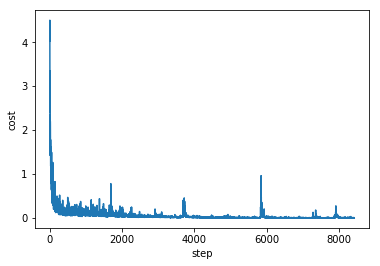

In [8]:
# Optional, print the cost per training step
import pylab
pylab.figure()
pylab.plot(costs)
pylab.xlabel('step')
pylab.ylabel('cost')
pylab.show()

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/training_records/checkpoint-8423


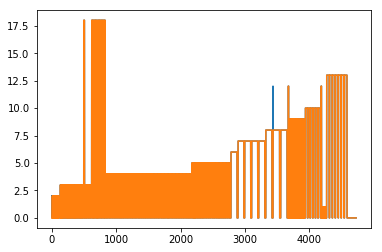

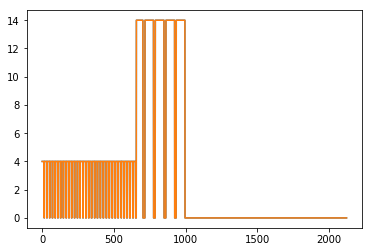

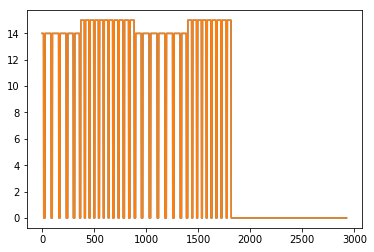

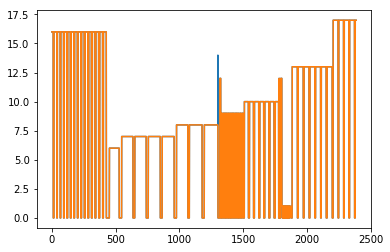

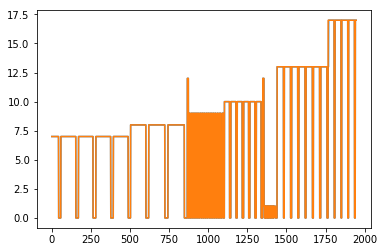

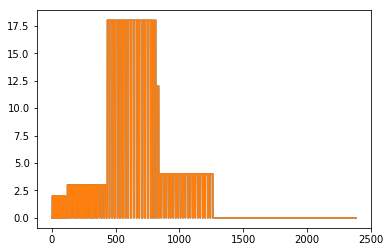

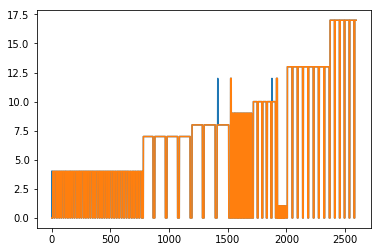

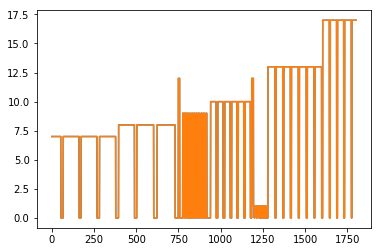

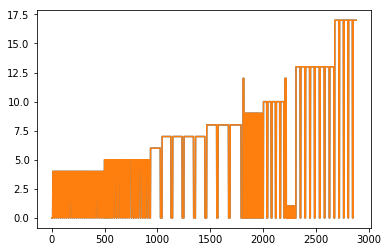

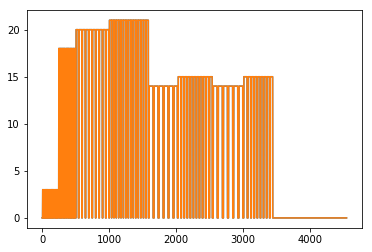

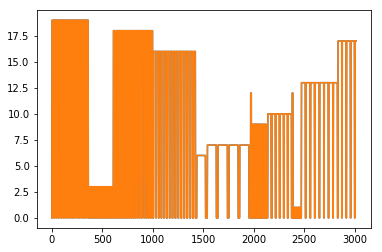

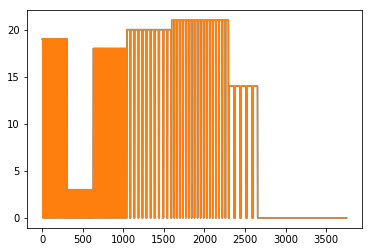

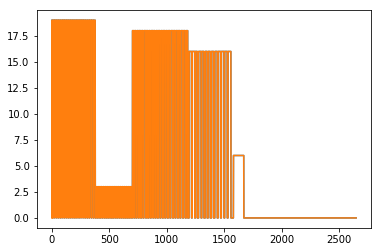

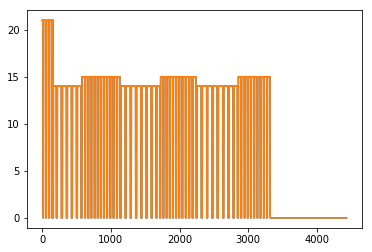

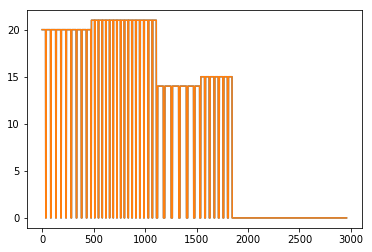

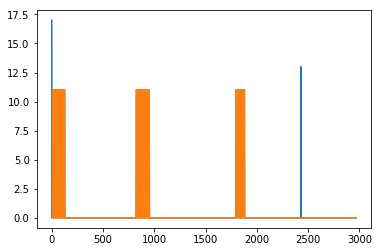

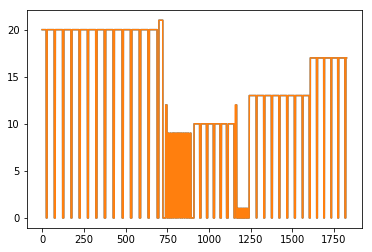

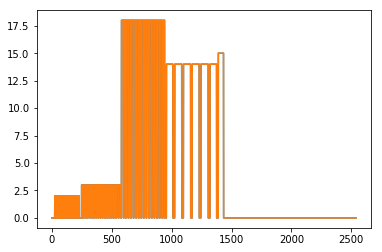

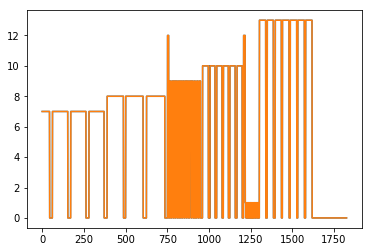

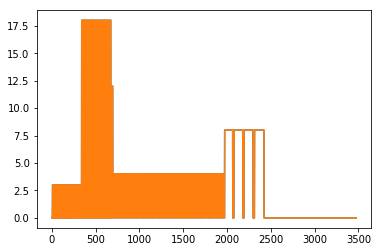

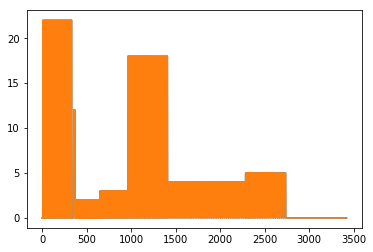

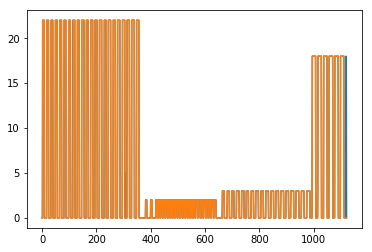

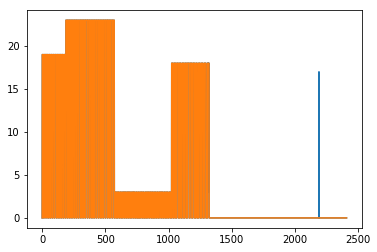

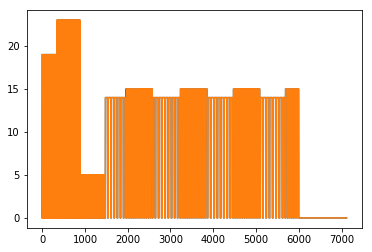

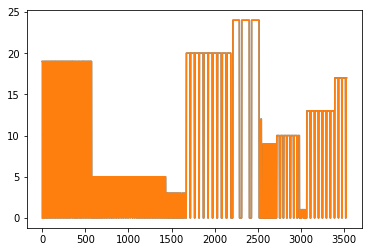

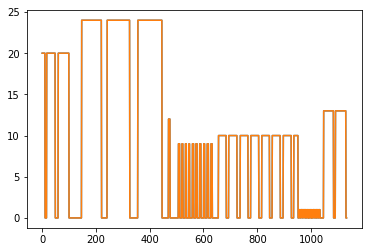

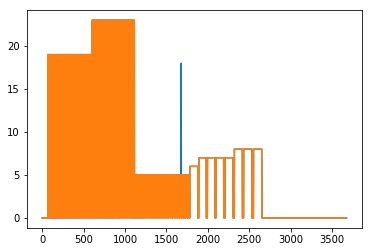

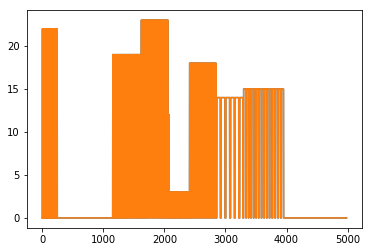

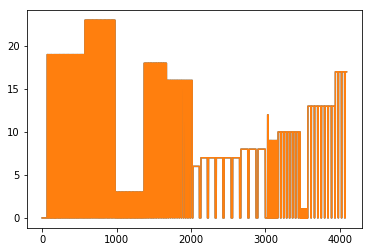

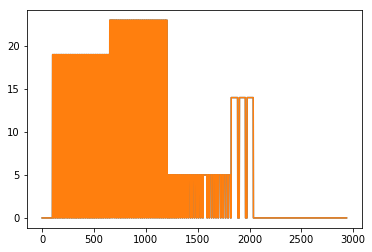

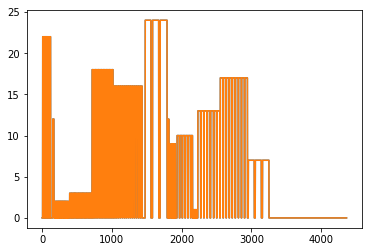

In [10]:
# Evaluate training set from a saved checkpoint. Remember to choose the correct checkpoint
import pylab

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-8423.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-8423"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    errors = []
    for file_num in range(number_of_files):
        # load current training file
        fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
        data = cpio.loadmat(data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        intY = data['labels'][0]
        
        temp_n = len(intY)/batch_size
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
        
        # Optional code for zero padding. Can replace the 3 lines above.
        #temp_n = data1.shape[0]/batch_size
        #rows_to_append = (temp_n + 1)*batch_size - data1.shape[0]
        #data1 = np.append(data1,np.zeros((rows_to_append,input_vec_size)),axis = 0)
        #intY = np.append(intY,np.zeros((rows_to_append,1)),axis = 0)
        #temp_n = temp_n + 1
        #data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
         
        d = {X: data1,Y:intY, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        errors.append(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)
        pylab.figure()
        pylab.plot(np.squeeze(pred[1]).reshape(-1))
        pylab.plot(intY.reshape(-1))
        pylab.show()

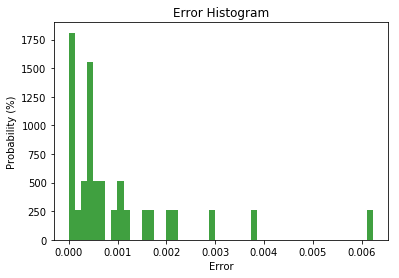

In [11]:
# Results on training set. Calculates the error histogram on the training set files. 
# Error is the fraction of mismatched bins.
pylab.figure()
n, bins, patches = pylab.hist([np.mean(err) for err in errors], 50, normed=True, facecolor='green', alpha=0.75)
pylab.xlabel('Error')
pylab.ylabel('Probability (%)')
pylab.title('Error Histogram')
pylab.show()
# print np.mean([np.mean(err) for err in errors]) # uncomment to calculate mean error

In [12]:
# Use the trained model to label the test set or unlabeled data.
# Remember to choose the correct checkpoint.
import glob
os.chdir(test_data_directory)
file_list = glob.glob('*.mat')

# Evaluate training set from a saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-8423.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-8423"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]

    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)

    # Run evaluation.
    # load current training file
    keys = np.zeros((len(file_list),), dtype=np.object)
    estimates = np.zeros((len(file_list),), dtype=np.object)
    file_num = 0
    for fname in file_list:
    #fname = file_list[file_num]
        print fname
        keys[file_num] = fname    
        data = cpio.loadmat(test_data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        print data1.shape
        temp_n = data1.shape[0]/batch_size
        rows_to_append = (temp_n + 1)*batch_size - data1.shape[0]
        data1 = np.append(data1,np.zeros((rows_to_append,input_vec_size)),axis = 0)
        print data1.shape
        temp_n = temp_n + 1
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        print data1.shape
        d = {X: data1, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        estim = np.squeeze(pred[1]).reshape(-1)
        estimates[file_num] = estim
        file_num = file_num + 1

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/training_records/checkpoint-8423
lbr3022_0001_2017_04_01_07_34_07.mat
(544, 513)
(550, 513)
(11, 50, 513)
lbr3022_0002_2017_04_05_07_36_25.mat
(553, 513)
(561, 513)
(11, 51, 513)
lbr3022_0003_2017_04_05_07_55_15.mat
(521, 513)
(528, 513)
(11, 48, 513)
lbr3022_0004_2017_04_05_09_18_48.mat
(535, 513)
(539, 513)
(11, 49, 513)
lbr3022_0005_2017_04_05_09_21_17.mat
(568, 513)
(572, 513)
(11, 52, 513)
lbr3022_0006_2017_04_05_10_01_07.mat
(1669, 513)
(1672, 513)
(11, 152, 513)
lbr3022_0007_2017_04_05_10_01_14.mat
(1785, 513)
(1793, 513)
(11, 163, 513)
lbr3022_0008_2017_04_05_10_01_55.mat
(1656, 513)
(1661, 513)
(11, 151, 513)
lbr3022_0009_2017_04_05_10_02_02.mat
(1472, 513)
(1474, 513)
(11, 134, 513)
lbr3022_0010_2017_04_05_10_02_20.mat
(1980, 513)
(1991, 513)
(11, 181, 513)
lbr3022_0011_2017_04_05_10_02_28.mat
(3747, 513)
(3751, 513)
(11, 341, 513)
lbr3022_0012_2017_04_05_10_11_38.mat
(11

lbr3022_0108_2017_04_12_07_30_59.mat
(2060, 513)
(2068, 513)
(11, 188, 513)
lbr3022_0109_2017_04_12_07_39_00.mat
(1971, 513)
(1980, 513)
(11, 180, 513)
lbr3022_0110_2017_04_12_07_39_08.mat
(3582, 513)
(3586, 513)
(11, 326, 513)
lbr3022_0111_2017_04_12_07_39_18.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lbr3022_0112_2017_04_12_07_39_25.mat
(3496, 513)
(3498, 513)
(11, 318, 513)
lbr3022_0113_2017_04_12_07_39_36.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_0114_2017_04_12_07_42_26.mat
(4347, 513)
(4356, 513)
(11, 396, 513)
lbr3022_0115_2017_04_12_07_42_39.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0116_2017_04_12_07_42_48.mat
(1885, 513)
(1892, 513)
(11, 172, 513)
lbr3022_0117_2017_04_12_07_42_54.mat
(2957, 513)
(2959, 513)
(11, 269, 513)
lbr3022_0118_2017_04_12_07_43_33.mat
(2501, 513)
(2508, 513)
(11, 228, 513)
lbr3022_0119_2017_04_12_08_28_41.mat
(3589, 513)
(3597, 513)
(11, 327, 513)
lbr3022_0120_2017_04_12_08_28_51.mat
(3017, 513)
(3025, 513)
(11, 275, 513)
lbr3022_0121

lbr3022_0216_2017_04_20_07_23_08.mat
(1354, 513)
(1364, 513)
(11, 124, 513)
lbr3022_0217_2017_04_20_07_23_14.mat
(2256, 513)
(2266, 513)
(11, 206, 513)
lbr3022_0218_2017_04_20_07_23_22.mat
(2795, 513)
(2805, 513)
(11, 255, 513)
lbr3022_0219_2017_04_20_07_23_38.mat
(1545, 513)
(1551, 513)
(11, 141, 513)
lbr3022_0220_2017_04_20_07_23_49.mat
(7094, 513)
(7095, 513)
(11, 645, 513)
lbr3022_0221_2017_04_20_07_24_11.mat
(1551, 513)
(1562, 513)
(11, 142, 513)
lbr3022_0222_2017_04_20_07_24_18.mat
(1354, 513)
(1364, 513)
(11, 124, 513)
lbr3022_0223_2017_04_20_07_24_23.mat
(2757, 513)
(2761, 513)
(11, 251, 513)
lbr3022_0224_2017_04_20_07_24_33.mat
(1541, 513)
(1551, 513)
(11, 141, 513)
lbr3022_0225_2017_04_20_07_24_42.mat
(1330, 513)
(1331, 513)
(11, 121, 513)
lbr3022_0226_2017_04_20_07_24_49.mat
(2388, 513)
(2398, 513)
(11, 218, 513)
lbr3022_0227_2017_04_20_07_24_58.mat
(1607, 513)
(1617, 513)
(11, 147, 513)
lbr3022_0228_2017_04_20_07_25_05.mat
(2511, 513)
(2519, 513)
(11, 229, 513)
lbr3022_0229

lbr3022_0324_2017_04_20_08_13_28.mat
(2697, 513)
(2706, 513)
(11, 246, 513)
lbr3022_0325_2017_04_20_08_13_39.mat
(1778, 513)
(1782, 513)
(11, 162, 513)
lbr3022_0326_2017_04_20_08_13_45.mat
(1679, 513)
(1683, 513)
(11, 153, 513)
lbr3022_0327_2017_04_20_08_13_51.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0328_2017_04_20_08_14_20.mat
(1971, 513)
(1980, 513)
(11, 180, 513)
lbr3022_0329_2017_04_20_08_15_20.mat
(1282, 513)
(1287, 513)
(11, 117, 513)
lbr3022_0330_2017_04_20_08_15_24.mat
(1467, 513)
(1474, 513)
(11, 134, 513)
lbr3022_0331_2017_04_20_08_15_29.mat
(1701, 513)
(1705, 513)
(11, 155, 513)
lbr3022_0332_2017_04_20_08_15_49.mat
(2046, 513)
(2057, 513)
(11, 187, 513)
lbr3022_0333_2017_04_20_08_15_58.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lbr3022_0334_2017_04_20_08_16_05.mat
(1245, 513)
(1254, 513)
(11, 114, 513)
lbr3022_0335_2017_04_20_08_16_11.mat
(2120, 513)
(2123, 513)
(11, 193, 513)
lbr3022_0336_2017_04_20_08_17_30.mat
(1559, 513)
(1562, 513)
(11, 142, 513)
lbr3022_0337

lbr3022_0432_2017_04_21_07_35_47.mat
(3442, 513)
(3443, 513)
(11, 313, 513)
lbr3022_0433_2017_04_21_07_36_01.mat
(2812, 513)
(2816, 513)
(11, 256, 513)
lbr3022_0434_2017_04_21_07_36_11.mat
(1961, 513)
(1969, 513)
(11, 179, 513)
lbr3022_0435_2017_04_21_07_36_24.mat
(4255, 513)
(4257, 513)
(11, 387, 513)
lbr3022_0436_2017_04_21_07_44_13.mat
(1174, 513)
(1177, 513)
(11, 107, 513)
lbr3022_0437_2017_04_21_07_44_18.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lbr3022_0438_2017_04_21_07_44_25.mat
(1347, 513)
(1353, 513)
(11, 123, 513)
lbr3022_0439_2017_04_21_07_47_03.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0440_2017_04_21_07_47_10.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_0441_2017_04_21_07_47_18.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_0442_2017_04_21_07_47_39.mat
(1209, 513)
(1210, 513)
(11, 110, 513)
lbr3022_0443_2017_04_21_07_47_47.mat
(2294, 513)
(2299, 513)
(11, 209, 513)
lbr3022_0444_2017_04_21_07_47_54.mat
(2731, 513)
(2739, 513)
(11, 249, 513)
lbr3022_0445

lbr3022_0540_2017_04_23_06_40_02.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lbr3022_0541_2017_04_23_06_40_20.mat
(2664, 513)
(2673, 513)
(11, 243, 513)
lbr3022_0542_2017_04_23_06_40_33.mat
(1884, 513)
(1892, 513)
(11, 172, 513)
lbr3022_0543_2017_04_23_06_50_34.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_0544_2017_04_23_06_50_38.mat
(3349, 513)
(3355, 513)
(11, 305, 513)
lbr3022_0545_2017_04_23_06_50_48.mat
(2541, 513)
(2552, 513)
(11, 232, 513)
lbr3022_0546_2017_04_23_06_50_57.mat
(1935, 513)
(1936, 513)
(11, 176, 513)
lbr3022_0547_2017_04_23_06_51_03.mat
(1937, 513)
(1947, 513)
(11, 177, 513)
lbr3022_0548_2017_04_23_06_51_19.mat
(2637, 513)
(2640, 513)
(11, 240, 513)
lbr3022_0549_2017_04_23_06_51_34.mat
(2682, 513)
(2684, 513)
(11, 244, 513)
lbr3022_0550_2017_04_23_06_51_45.mat
(3081, 513)
(3091, 513)
(11, 281, 513)
lbr3022_0551_2017_04_23_06_51_58.mat
(3572, 513)
(3575, 513)
(11, 325, 513)
lbr3022_0552_2017_04_23_06_52_17.mat
(1974, 513)
(1980, 513)
(11, 180, 513)
lbr3022_0553

lbr3022_0648_2017_04_25_07_58_42.mat
(3709, 513)
(3718, 513)
(11, 338, 513)
lbr3022_0649_2017_04_25_07_58_53.mat
(3857, 513)
(3861, 513)
(11, 351, 513)
lbr3022_0650_2017_04_25_07_59_10.mat
(3767, 513)
(3773, 513)
(11, 343, 513)
lbr3022_0651_2017_04_25_08_53_05.mat
(1430, 513)
(1441, 513)
(11, 131, 513)
lbr3022_0652_2017_04_25_08_53_13.mat
(1767, 513)
(1771, 513)
(11, 161, 513)
lbr3022_0653_2017_04_25_08_53_22.mat
(2062, 513)
(2068, 513)
(11, 188, 513)
lbr3022_0654_2017_04_25_08_53_34.mat
(3520, 513)
(3531, 513)
(11, 321, 513)
lbr3022_0655_2017_04_25_08_53_51.mat
(1980, 513)
(1991, 513)
(11, 181, 513)
lbr3022_0656_2017_04_25_08_54_03.mat
(1847, 513)
(1848, 513)
(11, 168, 513)
lbr3022_0657_2017_04_25_08_54_22.mat
(1245, 513)
(1254, 513)
(11, 114, 513)
lbr3022_0658_2017_04_25_08_54_25.mat
(1208, 513)
(1210, 513)
(11, 110, 513)
lbr3022_0659_2017_04_25_08_54_35.mat
(2662, 513)
(2673, 513)
(11, 243, 513)
lbr3022_0660_2017_04_25_08_54_55.mat
(1175, 513)
(1177, 513)
(11, 107, 513)
lbr3022_0661

lbr3022_0756_2017_04_30_07_00_44.mat
(2501, 513)
(2508, 513)
(11, 228, 513)
lbr3022_0757_2017_04_30_07_00_56.mat
(2356, 513)
(2365, 513)
(11, 215, 513)
lbr3022_0758_2017_04_30_07_11_48.mat
(1478, 513)
(1485, 513)
(11, 135, 513)
lbr3022_0759_2017_04_30_07_11_52.mat
(1143, 513)
(1144, 513)
(11, 104, 513)
lbr3022_0760_2017_04_30_07_28_13.mat
(2683, 513)
(2684, 513)
(11, 244, 513)
lbr3022_0761_2017_04_30_07_28_22.mat
(2730, 513)
(2739, 513)
(11, 249, 513)
lbr3022_0762_2017_04_30_07_28_46.mat
(1724, 513)
(1727, 513)
(11, 157, 513)
lbr3022_0763_2017_04_30_07_28_55.mat
(2759, 513)
(2761, 513)
(11, 251, 513)
lbr3022_0764_2017_04_30_07_29_06.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0765_2017_04_30_07_29_12.mat
(1331, 513)
(1342, 513)
(11, 122, 513)
lbr3022_0766_2017_04_30_07_29_19.mat
(1706, 513)
(1716, 513)
(11, 156, 513)
lbr3022_0767_2017_04_30_07_29_26.mat
(2612, 513)
(2618, 513)
(11, 238, 513)
lbr3022_0768_2017_04_30_07_29_41.mat
(2239, 513)
(2244, 513)
(11, 204, 513)
lbr3022_0769

lbr3022_0864_2017_05_03_08_38_35.mat
(1184, 513)
(1188, 513)
(11, 108, 513)
lbr3022_0865_2017_05_03_08_39_01.mat
(1430, 513)
(1441, 513)
(11, 131, 513)
lbr3022_0866_2017_05_03_08_40_40.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_0867_2017_05_03_08_43_36.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0868_2017_05_03_08_51_13.mat
(1229, 513)
(1232, 513)
(11, 112, 513)
lbr3022_0869_2017_05_04_06_05_36.mat
(3012, 513)
(3014, 513)
(11, 274, 513)
lbr3022_0870_2017_05_04_06_06_02.mat
(2600, 513)
(2607, 513)
(11, 237, 513)
lbr3022_0871_2017_05_04_06_10_24.mat
(5405, 513)
(5412, 513)
(11, 492, 513)
lbr3022_0872_2017_05_04_06_10_43.mat
(4158, 513)
(4169, 513)
(11, 379, 513)
lbr3022_0873_2017_05_04_06_11_00.mat
(4086, 513)
(4092, 513)
(11, 372, 513)
lbr3022_0874_2017_05_04_06_11_22.mat
(6110, 513)
(6116, 513)
(11, 556, 513)
lbr3022_0875_2017_05_04_06_11_50.mat
(4222, 513)
(4224, 513)
(11, 384, 513)
lbr3022_0876_2017_05_04_06_16_26.mat
(1176, 513)
(1177, 513)
(11, 107, 513)
lbr3022_0877

lbr3022_0972_2017_05_09_08_58_11.mat
(5035, 513)
(5038, 513)
(11, 458, 513)
lbr3022_0973_2017_05_10_08_29_45.mat
(4462, 513)
(4466, 513)
(11, 406, 513)
lbr3022_0974_2017_05_10_08_30_00.mat
(1343, 513)
(1353, 513)
(11, 123, 513)
lbr3022_0975_2017_05_10_08_30_11.mat
(2242, 513)
(2244, 513)
(11, 204, 513)
lbr3022_0976_2017_05_10_08_30_25.mat
(2974, 513)
(2981, 513)
(11, 271, 513)
lbr3022_0977_2017_05_10_08_31_23.mat
(1286, 513)
(1287, 513)
(11, 117, 513)
lbr3022_0978_2017_05_10_08_31_48.mat
(1384, 513)
(1386, 513)
(11, 126, 513)
lbr3022_0979_2017_05_11_06_21_30.mat
(2042, 513)
(2046, 513)
(11, 186, 513)
lbr3022_0980_2017_05_11_06_21_52.mat
(1906, 513)
(1914, 513)
(11, 174, 513)
lbr3022_0981_2017_05_11_06_21_59.mat
(2672, 513)
(2673, 513)
(11, 243, 513)
lbr3022_0982_2017_05_11_06_25_45.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0983_2017_05_11_06_25_48.mat
(3165, 513)
(3168, 513)
(11, 288, 513)
lbr3022_0984_2017_05_11_06_26_03.mat
(7908, 513)
(7909, 513)
(11, 719, 513)
lbr3022_0985

lbr3022_1080_2017_05_16_06_25_27.mat
(4537, 513)
(4543, 513)
(11, 413, 513)
lbr3022_1081_2017_05_16_06_25_40.mat
(2360, 513)
(2365, 513)
(11, 215, 513)
lbr3022_1082_2017_05_16_06_26_28.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1083_2017_05_16_06_26_40.mat
(1173, 513)
(1177, 513)
(11, 107, 513)
lbr3022_1084_2017_05_16_06_30_03.mat
(2593, 513)
(2596, 513)
(11, 236, 513)
lbr3022_1085_2017_05_16_06_50_16.mat
(2553, 513)
(2563, 513)
(11, 233, 513)
lbr3022_1086_2017_05_16_06_50_29.mat
(4503, 513)
(4510, 513)
(11, 410, 513)
lbr3022_1087_2017_05_16_06_58_37.mat
(2038, 513)
(2046, 513)
(11, 186, 513)
lbr3022_1088_2017_05_16_06_58_43.mat
(1496, 513)
(1507, 513)
(11, 137, 513)
lbr3022_1089_2017_05_16_06_59_12.mat
(2447, 513)
(2453, 513)
(11, 223, 513)
lbr3022_1090_2017_05_16_07_16_28.mat
(1335, 513)
(1342, 513)
(11, 122, 513)
lbr3022_1091_2017_05_16_07_16_42.mat
(2408, 513)
(2409, 513)
(11, 219, 513)
lbr3022_1092_2017_05_16_08_58_45.mat
(4029, 513)
(4037, 513)
(11, 367, 513)
lbr3022_1093

lbr3022_1188_2017_05_22_07_56_19.mat
(2454, 513)
(2464, 513)
(11, 224, 513)
lbr3022_1189_2017_05_22_07_56_29.mat
(2714, 513)
(2717, 513)
(11, 247, 513)
lbr3022_1190_2017_05_22_07_56_37.mat
(2122, 513)
(2123, 513)
(11, 193, 513)
lbr3022_1191_2017_05_22_07_57_13.mat
(1184, 513)
(1188, 513)
(11, 108, 513)
lbr3022_1192_2017_05_22_07_57_19.mat
(1826, 513)
(1837, 513)
(11, 167, 513)
lbr3022_1193_2017_05_22_07_57_25.mat
(2736, 513)
(2739, 513)
(11, 249, 513)
lbr3022_1194_2017_05_22_07_57_36.mat
(1664, 513)
(1672, 513)
(11, 152, 513)
lbr3022_1195_2017_05_22_07_57_45.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_1196_2017_05_22_07_57_52.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_1197_2017_05_22_07_57_57.mat
(2913, 513)
(2915, 513)
(11, 265, 513)
lbr3022_1198_2017_05_22_07_58_09.mat
(3727, 513)
(3729, 513)
(11, 339, 513)
lbr3022_1199_2017_05_22_07_58_23.mat
(1156, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1200_2017_05_22_07_58_51.mat
(3549, 513)
(3553, 513)
(11, 323, 513)
lbr3022_1201

lbr3022_1296_2017_05_24_06_56_48.mat
(3909, 513)
(3916, 513)
(11, 356, 513)
lbr3022_1297_2017_05_24_06_57_01.mat
(2281, 513)
(2288, 513)
(11, 208, 513)
lbr3022_1298_2017_05_24_06_57_58.mat
(1570, 513)
(1573, 513)
(11, 143, 513)
lbr3022_1299_2017_05_24_06_58_11.mat
(4307, 513)
(4312, 513)
(11, 392, 513)
lbr3022_1300_2017_05_24_06_58_33.mat
(4941, 513)
(4950, 513)
(11, 450, 513)
lbr3022_1301_2017_05_24_06_59_10.mat
(2091, 513)
(2101, 513)
(11, 191, 513)
lbr3022_1302_2017_05_24_06_59_17.mat
(3527, 513)
(3531, 513)
(11, 321, 513)
lbr3022_1303_2017_05_24_06_59_39.mat
(3322, 513)
(3333, 513)
(11, 303, 513)
lbr3022_1304_2017_05_24_06_59_48.mat
(1787, 513)
(1793, 513)
(11, 163, 513)
lbr3022_1305_2017_05_24_06_59_54.mat
(1380, 513)
(1386, 513)
(11, 126, 513)
lbr3022_1306_2017_05_24_07_00_16.mat
(6505, 513)
(6512, 513)
(11, 592, 513)
lbr3022_1307_2017_05_24_07_00_59.mat
(5237, 513)
(5247, 513)
(11, 477, 513)
lbr3022_1308_2017_05_24_07_01_13.mat
(2341, 513)
(2343, 513)
(11, 213, 513)
lbr3022_1309

lbr3022_1405_2017_05_25_07_00_39.mat
(1356, 513)
(1364, 513)
(11, 124, 513)
lbr3022_1406_2017_05_25_07_02_37.mat
(1148, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1407_2017_05_25_07_02_42.mat
(1601, 513)
(1606, 513)
(11, 146, 513)
lbr3022_1408_2017_05_25_07_02_50.mat
(1996, 513)
(2002, 513)
(11, 182, 513)
lbr3022_1409_2017_05_25_07_03_04.mat
(2369, 513)
(2376, 513)
(11, 216, 513)
lbr3022_1410_2017_05_25_07_03_18.mat
(1510, 513)
(1518, 513)
(11, 138, 513)
lbr3022_1411_2017_05_25_07_03_22.mat
(1928, 513)
(1936, 513)
(11, 176, 513)
lbr3022_1412_2017_05_25_07_03_28.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1413_2017_05_25_07_03_45.mat
(2831, 513)
(2838, 513)
(11, 258, 513)
lbr3022_1414_2017_05_25_07_04_00.mat
(2831, 513)
(2838, 513)
(11, 258, 513)
lbr3022_1415_2017_05_25_07_04_08.mat
(1922, 513)
(1925, 513)
(11, 175, 513)
lbr3022_1416_2017_05_25_07_04_34.mat
(2760, 513)
(2761, 513)
(11, 251, 513)
lbr3022_1417_2017_05_25_07_04_42.mat
(1614, 513)
(1617, 513)
(11, 147, 513)
lbr3022_1418

lbr3022_1514_2017_05_26_07_46_40.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_1515_2017_05_26_07_50_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1516_2017_05_26_07_53_24.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1517_2017_05_26_07_53_43.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1518_2017_05_26_07_57_53.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1519_2017_05_26_07_59_14.mat
(2809, 513)
(2816, 513)
(11, 256, 513)
lbr3022_1520_2017_05_26_07_59_29.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_1521_2017_05_26_07_59_33.mat
(2551, 513)
(2552, 513)
(11, 232, 513)
lbr3022_1522_2017_05_26_08_00_02.mat
(3191, 513)
(3201, 513)
(11, 291, 513)
lbr3022_1523_2017_05_26_08_00_16.mat
(3673, 513)
(3674, 513)
(11, 334, 513)
lbr3022_1524_2017_05_26_08_01_50.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1525_2017_05_26_08_02_26.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_1526_2017_05_26_08_02_31.mat
(1797, 513)
(1804, 513)
(11, 164, 513)
lbr3022_1527

lbr3022_1623_2017_05_30_06_39_53.mat
(4571, 513)
(4576, 513)
(11, 416, 513)
lbr3022_1624_2017_05_30_06_40_29.mat
(1531, 513)
(1540, 513)
(11, 140, 513)
lbr3022_1625_2017_05_30_06_40_33.mat
(4690, 513)
(4697, 513)
(11, 427, 513)
lbr3022_1626_2017_05_30_06_41_26.mat
(3241, 513)
(3245, 513)
(11, 295, 513)
lbr3022_1627_2017_05_30_06_41_36.mat
(1812, 513)
(1815, 513)
(11, 165, 513)
lbr3022_1628_2017_05_30_06_41_42.mat
(1836, 513)
(1837, 513)
(11, 167, 513)
lbr3022_1629_2017_05_30_06_41_48.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1630_2017_05_30_06_42_09.mat
(2526, 513)
(2530, 513)
(11, 230, 513)
lbr3022_1631_2017_05_30_06_42_22.mat
(5933, 513)
(5940, 513)
(11, 540, 513)
lbr3022_1632_2017_05_30_06_42_59.mat
(2656, 513)
(2662, 513)
(11, 242, 513)
lbr3022_1633_2017_05_30_06_43_15.mat
(2634, 513)
(2640, 513)
(11, 240, 513)
lbr3022_1634_2017_05_30_06_43_50.mat
(3636, 513)
(3641, 513)
(11, 331, 513)
lbr3022_1635_2017_05_30_06_44_01.mat
(1775, 513)
(1782, 513)
(11, 162, 513)
lbr3022_1636

lbr3022_1731_2017_05_31_07_25_21.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_1732_2017_05_31_07_43_07.mat
(1386, 513)
(1397, 513)
(11, 127, 513)
lbr3022_1733_2017_05_31_07_44_09.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_1734_2017_05_31_07_46_17.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1735_2017_05_31_07_46_57.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_1736_2017_05_31_07_51_34.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1737_2017_05_31_07_51_37.mat
(1145, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1738_2017_05_31_07_51_43.mat
(1690, 513)
(1694, 513)
(11, 154, 513)
lbr3022_1739_2017_05_31_07_51_49.mat
(1739, 513)
(1749, 513)
(11, 159, 513)
lbr3022_1740_2017_05_31_08_18_47.mat
(1613, 513)
(1617, 513)
(11, 147, 513)
lbr3022_1741_2017_05_31_08_19_22.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1742_2017_06_05_00_23_48.mat
(582, 513)
(583, 513)
(11, 53, 513)
lbr3022_1743_2017_06_05_00_30_01.mat
(555, 513)
(561, 513)
(11, 51, 513)
lbr3022_1744_2017_

lbr3022_1841_2017_06_06_06_11_12.mat
(1163, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1842_2017_06_06_06_11_16.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1843_2017_06_06_06_11_24.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lbr3022_1844_2017_06_06_06_11_27.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1845_2017_06_06_06_11_31.mat
(1179, 513)
(1188, 513)
(11, 108, 513)
lbr3022_1846_2017_06_06_06_11_39.mat
(2378, 513)
(2387, 513)
(11, 217, 513)
lbr3022_1847_2017_06_06_06_11_50.mat
(2120, 513)
(2123, 513)
(11, 193, 513)
lbr3022_1848_2017_06_06_06_12_02.mat
(2729, 513)
(2739, 513)
(11, 249, 513)
lbr3022_1849_2017_06_06_06_12_18.mat
(1319, 513)
(1320, 513)
(11, 120, 513)
lbr3022_1850_2017_06_06_06_12_25.mat
(3022, 513)
(3025, 513)
(11, 275, 513)
lbr3022_1851_2017_06_06_06_13_10.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1852_2017_06_06_06_20_08.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1853_2017_06_06_06_20_25.mat
(1161, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1854

lbr3022_1949_2017_06_07_06_26_28.mat
(3189, 513)
(3190, 513)
(11, 290, 513)
lbr3022_1950_2017_06_07_06_26_37.mat
(1807, 513)
(1815, 513)
(11, 165, 513)
lbr3022_1951_2017_06_07_06_26_43.mat
(1563, 513)
(1573, 513)
(11, 143, 513)
lbr3022_1952_2017_06_07_06_27_14.mat
(4200, 513)
(4202, 513)
(11, 382, 513)
lbr3022_1953_2017_06_07_06_27_27.mat
(1783, 513)
(1793, 513)
(11, 163, 513)
lbr3022_1954_2017_06_07_06_27_33.mat
(1563, 513)
(1573, 513)
(11, 143, 513)
lbr3022_1955_2017_06_07_06_28_07.mat
(3577, 513)
(3586, 513)
(11, 326, 513)
lbr3022_1956_2017_06_07_06_28_18.mat
(1790, 513)
(1793, 513)
(11, 163, 513)
lbr3022_1957_2017_06_07_06_28_24.mat
(1912, 513)
(1914, 513)
(11, 174, 513)
lbr3022_1958_2017_06_07_06_28_31.mat
(1473, 513)
(1474, 513)
(11, 134, 513)
lbr3022_1959_2017_06_07_06_48_52.mat
(2412, 513)
(2420, 513)
(11, 220, 513)
lbr3022_1960_2017_06_07_06_49_10.mat
(2315, 513)
(2321, 513)
(11, 211, 513)
lbr3022_1961_2017_06_07_06_49_28.mat
(3289, 513)
(3300, 513)
(11, 300, 513)
lbr3022_1962

lbr3022_2057_2017_06_08_07_11_54.mat
(1519, 513)
(1529, 513)
(11, 139, 513)
lbr3022_2058_2017_06_08_07_34_36.mat
(3191, 513)
(3201, 513)
(11, 291, 513)
lbr3022_2059_2017_06_08_07_35_10.mat
(3206, 513)
(3212, 513)
(11, 292, 513)
lbr3022_2060_2017_06_09_07_23_57.mat
(1704, 513)
(1705, 513)
(11, 155, 513)
lbr3022_2061_2017_06_09_07_24_34.mat
(2723, 513)
(2728, 513)
(11, 248, 513)
lbr3022_2062_2017_06_09_07_24_43.mat
(1787, 513)
(1793, 513)
(11, 163, 513)
lbr3022_2063_2017_06_09_07_25_56.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lbr3022_2064_2017_06_13_00_11_25.mat
(568, 513)
(572, 513)
(11, 52, 513)
lbr3022_2065_2017_06_13_00_25_32.mat
(592, 513)
(594, 513)
(11, 54, 513)
lbr3022_2066_2017_06_13_00_28_44.mat
(571, 513)
(572, 513)
(11, 52, 513)
lbr3022_2067_2017_06_13_00_31_46.mat
(555, 513)
(561, 513)
(11, 51, 513)
lbr3022_2068_2017_06_13_01_17_43.mat
(591, 513)
(594, 513)
(11, 54, 513)
lbr3022_2069_2017_06_13_01_18_00.mat
(554, 513)
(561, 513)
(11, 51, 513)
lbr3022_2070_2017_06_13_01_18_

lbr3022_2166_2017_06_13_08_25_27.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2167_2017_06_13_08_28_08.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2168_2017_06_13_08_36_34.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2169_2017_06_13_23_22_50.mat
(1628, 513)
(1639, 513)
(11, 149, 513)
lbr3022_2170_2017_06_13_23_31_11.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2171_2017_06_13_23_41_10.mat
(1136, 513)
(1144, 513)
(11, 104, 513)
lbr3022_2172_2017_06_13_23_45_50.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2173_2017_06_14_00_31_07.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2174_2017_06_14_00_38_28.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2175_2017_06_14_01_16_22.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2176_2017_06_14_01_21_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2177_2017_06_14_01_24_32.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2178_2017_06_14_02_30_37.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2179

lbr3022_2274_2017_06_14_05_59_08.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lbr3022_2275_2017_06_14_05_59_58.mat
(7118, 513)
(7128, 513)
(11, 648, 513)
lbr3022_2276_2017_06_14_06_00_42.mat
(3942, 513)
(3949, 513)
(11, 359, 513)
lbr3022_2277_2017_06_14_06_00_54.mat
(2021, 513)
(2024, 513)
(11, 184, 513)
lbr3022_2278_2017_06_14_06_01_00.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lbr3022_2279_2017_06_14_06_01_18.mat
(5390, 513)
(5401, 513)
(11, 491, 513)
lbr3022_2280_2017_06_14_06_01_48.mat
(4041, 513)
(4048, 513)
(11, 368, 513)
lbr3022_2281_2017_06_14_06_01_59.mat
(1836, 513)
(1837, 513)
(11, 167, 513)
lbr3022_2282_2017_06_14_06_02_20.mat
(3925, 513)
(3927, 513)
(11, 357, 513)
lbr3022_2283_2017_06_14_06_02_32.mat
(1739, 513)
(1749, 513)
(11, 159, 513)
lbr3022_2284_2017_06_14_06_03_16.mat
(4451, 513)
(4455, 513)
(11, 405, 513)
lbr3022_2285_2017_06_14_06_03_29.mat
(1818, 513)
(1826, 513)
(11, 166, 513)
lbr3022_2286_2017_06_14_06_03_35.mat
(1391, 513)
(1397, 513)
(11, 127, 513)
lbr3022_2287

lbr3022_2383_2017_06_15_03_59_19.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_2384_2017_06_15_04_22_23.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2385_2017_06_15_05_07_01.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2386_2017_06_15_05_07_08.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2387_2017_06_15_05_07_42.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2388_2017_06_15_05_08_35.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2389_2017_06_15_05_08_52.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2390_2017_06_15_05_09_24.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2391_2017_06_15_05_09_34.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2392_2017_06_15_05_09_38.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2393_2017_06_15_05_09_53.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2394_2017_06_15_05_10_52.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2395_2017_06_15_05_11_36.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2396

lbr3022_2491_2017_06_15_06_43_05.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2492_2017_06_15_06_43_31.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lbr3022_2493_2017_06_15_06_43_45.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2494_2017_06_15_06_44_09.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2495_2017_06_15_06_44_46.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2496_2017_06_15_06_44_51.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2497_2017_06_15_06_45_08.mat
(1195, 513)
(1199, 513)
(11, 109, 513)
lbr3022_2498_2017_06_15_06_45_26.mat
(1947, 513)
(1958, 513)
(11, 178, 513)
lbr3022_2499_2017_06_15_06_45_37.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2500_2017_06_15_06_46_13.mat
(2211, 513)
(2222, 513)
(11, 202, 513)
lbr3022_2501_2017_06_15_06_46_19.mat
(1573, 513)
(1584, 513)
(11, 144, 513)
lbr3022_2502_2017_06_15_06_46_46.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2503_2017_06_15_06_47_00.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2504

lbr3022_2599_2017_06_15_08_04_41.mat
(1130, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2600_2017_06_15_08_04_45.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2601_2017_06_15_08_05_21.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2602_2017_06_15_08_05_41.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2603_2017_06_15_08_05_48.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_2604_2017_06_15_08_05_59.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_2605_2017_06_15_08_06_08.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2606_2017_06_15_08_09_15.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2607_2017_06_15_08_11_11.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2608_2017_06_15_08_12_55.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2609_2017_06_15_08_16_34.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2610_2017_06_15_08_16_56.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2611_2017_06_15_08_18_05.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2612

lbr3022_2707_2017_06_15_10_17_57.mat
(2059, 513)
(2068, 513)
(11, 188, 513)
lbr3022_2708_2017_06_15_10_18_14.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2709_2017_06_15_10_18_41.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2710_2017_06_15_10_19_16.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2711_2017_06_15_10_19_45.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2712_2017_06_15_10_20_32.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2713_2017_06_15_10_21_26.mat
(1148, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2714_2017_06_15_10_21_48.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2715_2017_06_15_10_22_03.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2716_2017_06_15_10_22_10.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2717_2017_06_15_10_23_44.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2718_2017_06_15_10_24_52.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2719_2017_06_15_10_24_56.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2720

lbr3022_2815_2017_06_15_11_38_50.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2816_2017_06_15_11_39_56.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2817_2017_06_15_11_40_12.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2818_2017_06_15_11_41_45.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_2819_2017_06_15_11_42_40.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2820_2017_06_15_11_43_15.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2821_2017_06_15_11_43_45.mat
(2526, 513)
(2530, 513)
(11, 230, 513)
lbr3022_2822_2017_06_15_11_45_44.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2823_2017_06_15_11_46_36.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2824_2017_06_15_11_47_59.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2825_2017_06_15_11_48_48.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2826_2017_06_15_11_48_53.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2827_2017_06_15_11_49_04.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2828

lbr3022_2923_2017_06_15_12_23_49.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2924_2017_06_15_12_23_55.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_2925_2017_06_15_12_23_58.mat
(4218, 513)
(4224, 513)
(11, 384, 513)
lbr3022_2926_2017_06_15_12_24_11.mat
(1286, 513)
(1287, 513)
(11, 117, 513)
lbr3022_2927_2017_06_15_12_24_23.mat
(3676, 513)
(3685, 513)
(11, 335, 513)
lbr3022_2928_2017_06_15_12_24_34.mat
(1857, 513)
(1859, 513)
(11, 169, 513)
lbr3022_2929_2017_06_15_12_24_40.mat
(1863, 513)
(1870, 513)
(11, 170, 513)
lbr3022_2930_2017_06_15_12_24_55.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2931_2017_06_15_12_25_01.mat
(2867, 513)
(2871, 513)
(11, 261, 513)
lbr3022_2932_2017_06_15_12_25_09.mat
(3371, 513)
(3377, 513)
(11, 307, 513)
lbr3022_2933_2017_06_15_12_25_20.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2934_2017_06_15_12_25_24.mat
(4731, 513)
(4741, 513)
(11, 431, 513)
lbr3022_2935_2017_06_15_12_25_50.mat
(3799, 513)
(3806, 513)
(11, 346, 513)
lbr3022_2936

lbr3022_3031_2017_06_15_12_47_11.mat
(11845, 513)
(11847, 513)
(11, 1077, 513)
lbr3022_3032_2017_06_15_12_47_44.mat
(2525, 513)
(2530, 513)
(11, 230, 513)
lbr3022_3033_2017_06_15_12_47_51.mat
(9628, 513)
(9636, 513)
(11, 876, 513)
lbr3022_3034_2017_06_15_12_48_17.mat
(7391, 513)
(7392, 513)
(11, 672, 513)
lbr3022_3035_2017_06_15_12_48_38.mat
(3142, 513)
(3146, 513)
(11, 286, 513)
lbr3022_3036_2017_06_15_12_48_47.mat
(1765, 513)
(1771, 513)
(11, 161, 513)
lbr3022_3037_2017_06_15_12_48_52.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_3038_2017_06_15_12_49_01.mat
(4904, 513)
(4906, 513)
(11, 446, 513)
lbr3022_3039_2017_06_15_12_49_17.mat
(1216, 513)
(1221, 513)
(11, 111, 513)
lbr3022_3040_2017_06_15_12_49_30.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3041_2017_06_15_12_49_33.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_3042_2017_06_15_12_50_15.mat
(4206, 513)
(4213, 513)
(11, 383, 513)
lbr3022_3043_2017_06_15_12_50_27.mat
(2097, 513)
(2101, 513)
(11, 191, 513)
lbr3022_3

lbr3022_3139_2017_06_15_13_31_56.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3140_2017_06_15_13_32_14.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3141_2017_06_15_13_32_36.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3142_2017_06_15_13_33_39.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3143_2017_06_15_13_33_52.mat
(1480, 513)
(1485, 513)
(11, 135, 513)
lbr3022_3144_2017_06_15_13_34_41.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3145_2017_06_15_13_34_52.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3146_2017_06_15_13_36_38.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3147_2017_06_15_13_37_23.mat
(1660, 513)
(1661, 513)
(11, 151, 513)
lbr3022_3148_2017_06_15_13_38_35.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3149_2017_06_15_13_39_21.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3150_2017_06_15_13_40_02.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3151_2017_06_15_13_40_50.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3152

lbr3022_3247_2017_06_15_14_59_39.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3248_2017_06_15_15_00_13.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3249_2017_06_15_15_00_39.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3250_2017_06_15_15_01_10.mat
(1379, 513)
(1386, 513)
(11, 126, 513)
lbr3022_3251_2017_06_15_15_01_22.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3252_2017_06_15_15_01_36.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3253_2017_06_15_15_02_53.mat
(1158, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3254_2017_06_15_15_03_29.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3255_2017_06_15_15_03_44.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3256_2017_06_15_15_05_38.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3257_2017_06_15_15_07_04.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3258_2017_06_15_15_08_56.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3259_2017_06_15_15_10_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3260

lbr3022_3355_2017_06_15_17_27_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3356_2017_06_15_17_31_40.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3357_2017_06_15_17_34_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3358_2017_06_15_17_34_26.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3359_2017_06_15_17_35_20.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3360_2017_06_15_17_35_27.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3361_2017_06_15_17_38_08.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3362_2017_06_15_17_38_54.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3363_2017_06_15_17_40_35.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3364_2017_06_15_17_40_44.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3365_2017_06_15_17_40_52.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3366_2017_06_15_17_42_19.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3367_2017_06_15_17_43_20.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3368

lbr3022_3463_2017_06_15_19_00_44.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3464_2017_06_15_19_00_50.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3465_2017_06_15_19_01_24.mat
(1221, 513)
(1232, 513)
(11, 112, 513)
lbr3022_3466_2017_06_15_19_01_47.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3467_2017_06_15_19_03_06.mat
(1762, 513)
(1771, 513)
(11, 161, 513)
lbr3022_3468_2017_06_15_19_03_13.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3469_2017_06_15_19_03_22.mat
(1366, 513)
(1375, 513)
(11, 125, 513)
lbr3022_3470_2017_06_15_19_04_24.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3471_2017_06_15_19_11_41.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3472_2017_06_15_19_13_37.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3473_2017_06_15_19_21_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3474_2017_06_15_19_21_46.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3475_2017_06_15_19_22_26.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3476

lbr3022_3571_2017_06_15_23_09_15.mat
(1553, 513)
(1562, 513)
(11, 142, 513)
lbr3022_3572_2017_06_15_23_09_40.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3573_2017_06_15_23_10_48.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3574_2017_06_15_23_20_57.mat
(1072, 513)
(1078, 513)
(11, 98, 513)
lbr3022_3575_2017_06_15_23_23_30.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3576_2017_06_15_23_26_37.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3577_2017_06_15_23_48_50.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3578_2017_06_15_23_49_25.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3579_2017_06_15_23_53_23.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3580_2017_06_15_23_55_34.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3581_2017_06_15_23_59_43.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3582_2017_06_16_00_00_10.mat
(1160, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3583_2017_06_16_00_02_11.mat
(1553, 513)
(1562, 513)
(11, 142, 513)
lbr3022_3584_

lbr3022_3679_2017_06_16_05_40_06.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3680_2017_06_16_05_40_51.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3681_2017_06_16_05_41_58.mat
(1130, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3682_2017_06_16_05_42_51.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3683_2017_06_16_05_44_48.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3684_2017_06_16_05_45_18.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3685_2017_06_16_05_45_36.mat
(1768, 513)
(1771, 513)
(11, 161, 513)
lbr3022_3686_2017_06_16_05_45_42.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3687_2017_06_16_05_45_46.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3688_2017_06_16_05_45_56.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3689_2017_06_16_05_46_09.mat
(2304, 513)
(2310, 513)
(11, 210, 513)
lbr3022_3690_2017_06_16_05_46_30.mat
(1229, 513)
(1232, 513)
(11, 112, 513)
lbr3022_3691_2017_06_16_05_46_34.mat
(2177, 513)
(2178, 513)
(11, 198, 513)
lbr3022_3692

lbr3022_3787_2017_06_16_07_26_10.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3788_2017_06_16_07_34_26.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3789_2017_06_16_07_34_47.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3790_2017_06_16_07_35_16.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3791_2017_06_16_07_36_10.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3792_2017_06_16_07_38_36.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3793_2017_06_16_07_39_50.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3794_2017_06_16_07_48_36.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3795_2017_06_16_07_53_20.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3796_2017_06_16_08_01_22.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3797_2017_06_16_08_02_11.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3798_2017_06_16_08_02_17.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3799_2017_06_16_08_03_47.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3800

lbr3022_3896_2017_06_19_05_32_40.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3897_2017_06_19_05_33_00.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lbr3022_3898_2017_06_19_05_33_17.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lbr3022_3899_2017_06_19_05_33_31.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3900_2017_06_19_05_34_14.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3901_2017_06_19_05_35_00.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3902_2017_06_19_05_35_56.mat
(1093, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3903_2017_06_19_05_36_33.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3904_2017_06_19_05_36_37.mat
(1081, 513)
(1089, 513)
(11, 99, 513)
lbr3022_3905_2017_06_19_05_36_54.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3906_2017_06_19_05_38_32.mat
(2254, 513)
(2255, 513)
(11, 205, 513)
lbr3022_3907_2017_06_19_05_38_39.mat
(2221, 513)
(2222, 513)
(11, 202, 513)
lbr3022_3908_2017_06_19_05_38_45.mat
(1910, 513)
(1914, 513)
(11, 174, 513)
lbr3022_3909_

lbr3022_4004_2017_06_19_06_22_47.mat
(2046, 513)
(2057, 513)
(11, 187, 513)
lbr3022_4005_2017_06_19_06_22_56.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4006_2017_06_19_06_22_59.mat
(1358, 513)
(1364, 513)
(11, 124, 513)
lbr3022_4007_2017_06_19_06_23_17.mat
(1889, 513)
(1892, 513)
(11, 172, 513)
lbr3022_4008_2017_06_19_06_23_31.mat
(4048, 513)
(4059, 513)
(11, 369, 513)
lbr3022_4009_2017_06_19_06_23_42.mat
(2042, 513)
(2046, 513)
(11, 186, 513)
lbr3022_4010_2017_06_19_06_23_48.mat
(1530, 513)
(1540, 513)
(11, 140, 513)
lbr3022_4011_2017_06_19_06_25_00.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4012_2017_06_19_06_28_04.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4013_2017_06_19_06_29_08.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_4014_2017_06_19_06_29_15.mat
(4165, 513)
(4169, 513)
(11, 379, 513)
lbr3022_4015_2017_06_19_06_29_47.mat
(2701, 513)
(2706, 513)
(11, 246, 513)
lbr3022_4016_2017_06_19_06_29_58.mat
(3241, 513)
(3245, 513)
(11, 295, 513)
lbr3022_4017

lbr3022_4112_2017_06_19_08_10_18.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4113_2017_06_19_08_10_54.mat
(2228, 513)
(2233, 513)
(11, 203, 513)
lbr3022_4114_2017_06_19_08_11_32.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4115_2017_06_19_08_11_44.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4116_2017_06_19_08_13_14.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4117_2017_06_19_08_13_18.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_4118_2017_06_19_08_15_41.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4119_2017_06_19_08_19_39.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4120_2017_06_19_08_19_50.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lbr3022_4121_2017_06_19_08_19_57.mat
(3807, 513)
(3817, 513)
(11, 347, 513)
lbr3022_4122_2017_06_19_08_20_14.mat
(1103, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4123_2017_06_19_08_20_18.mat
(1454, 513)
(1463, 513)
(11, 133, 513)
lbr3022_4124_2017_06_19_08_20_22.mat
(2551, 513)
(2552, 513)
(11, 232, 513)
lbr3022_4125

lbr3022_4220_2017_06_20_05_46_48.mat
(2189, 513)
(2200, 513)
(11, 200, 513)
lbr3022_4221_2017_06_20_05_46_54.mat
(1541, 513)
(1551, 513)
(11, 141, 513)
lbr3022_4222_2017_06_20_05_47_13.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4223_2017_06_20_05_47_24.mat
(5486, 513)
(5489, 513)
(11, 499, 513)
lbr3022_4224_2017_06_20_05_48_07.mat
(7331, 513)
(7337, 513)
(11, 667, 513)
lbr3022_4225_2017_06_20_05_48_38.mat
(4237, 513)
(4246, 513)
(11, 386, 513)
lbr3022_4226_2017_06_20_05_48_49.mat
(2193, 513)
(2200, 513)
(11, 200, 513)
lbr3022_4227_2017_06_20_05_48_56.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lbr3022_4228_2017_06_20_05_49_22.mat
(5264, 513)
(5269, 513)
(11, 479, 513)
lbr3022_4229_2017_06_20_05_50_33.mat
(5784, 513)
(5786, 513)
(11, 526, 513)
lbr3022_4230_2017_06_20_05_50_49.mat
(1873, 513)
(1881, 513)
(11, 171, 513)
lbr3022_4231_2017_06_20_05_57_28.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4232_2017_06_20_05_59_57.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4233

lbr3022_4328_2017_06_20_07_18_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4329_2017_06_20_07_20_50.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4330_2017_06_20_07_21_43.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_4331_2017_06_20_07_22_32.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4332_2017_06_20_07_23_19.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4333_2017_06_20_07_25_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4334_2017_06_20_07_25_31.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_4335_2017_06_20_07_25_36.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_4336_2017_06_20_07_27_07.mat
(1103, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4337_2017_06_20_07_28_01.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4338_2017_06_20_07_29_24.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4339_2017_06_20_07_31_20.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lbr3022_4340_2017_06_20_07_31_39.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_4341_

lbr3022_4437_2017_06_21_05_19_33.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_4438_2017_06_21_05_21_11.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4439_2017_06_21_05_28_08.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4440_2017_06_21_05_29_03.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4441_2017_06_21_05_29_50.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4442_2017_06_21_05_29_55.mat
(1082, 513)
(1089, 513)
(11, 99, 513)
lbr3022_4443_2017_06_21_05_30_10.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4444_2017_06_21_05_31_31.mat
(1136, 513)
(1144, 513)
(11, 104, 513)
lbr3022_4445_2017_06_21_05_31_36.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4446_2017_06_21_05_31_45.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4447_2017_06_21_05_31_56.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4448_2017_06_21_05_39_46.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4449_2017_06_21_05_43_33.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4450_

lbr3022_4545_2017_06_21_08_31_08.mat
(1083, 513)
(1089, 513)
(11, 99, 513)
lbr3022_4546_2017_06_21_08_36_46.mat
(2005, 513)
(2013, 513)
(11, 183, 513)
lbr3022_4547_2017_06_21_08_36_56.mat
(1208, 513)
(1210, 513)
(11, 110, 513)
lbr3022_4548_2017_06_21_08_37_10.mat
(2023, 513)
(2024, 513)
(11, 184, 513)
lbr3022_4549_2017_06_21_08_37_21.mat
(2964, 513)
(2970, 513)
(11, 270, 513)
lbr3022_4550_2017_06_21_08_37_39.mat
(1519, 513)
(1529, 513)
(11, 139, 513)
lbr3022_4551_2017_06_21_08_38_00.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4552_2017_06_22_00_22_52.mat
(512, 513)
(517, 513)
(11, 47, 513)
lbr3022_4553_2017_06_22_01_45_21.mat
(552, 513)
(561, 513)
(11, 51, 513)
lbr3022_4554_2017_06_22_01_45_33.mat
(554, 513)
(561, 513)
(11, 51, 513)
lbr3022_4555_2017_06_22_01_52_35.mat
(1230, 513)
(1232, 513)
(11, 112, 513)
lbr3022_4556_2017_06_22_05_08_58.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4557_2017_06_22_05_09_11.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4558_2017_06_2

lbr3022_4654_2017_06_23_05_46_37.mat
(2068, 513)
(2079, 513)
(11, 189, 513)
lbr3022_4655_2017_06_23_05_46_43.mat
(1579, 513)
(1584, 513)
(11, 144, 513)
lbr3022_4656_2017_06_23_05_47_05.mat
(4364, 513)
(4367, 513)
(11, 397, 513)
lbr3022_4657_2017_06_23_05_47_17.mat
(2048, 513)
(2057, 513)
(11, 187, 513)
lbr3022_4658_2017_06_23_05_47_23.mat
(2121, 513)
(2123, 513)
(11, 193, 513)
lbr3022_4659_2017_06_23_05_47_29.mat
(1356, 513)
(1364, 513)
(11, 124, 513)
lbr3022_4660_2017_06_23_05_48_12.mat
(3770, 513)
(3773, 513)
(11, 343, 513)
lbr3022_4661_2017_06_23_05_48_23.mat
(1967, 513)
(1969, 513)
(11, 179, 513)
lbr3022_4662_2017_06_23_05_48_28.mat
(1692, 513)
(1694, 513)
(11, 154, 513)
lbr3022_4663_2017_06_23_05_48_58.mat
(5692, 513)
(5698, 513)
(11, 518, 513)
lbr3022_4664_2017_06_23_05_49_24.mat
(5052, 513)
(5060, 513)
(11, 460, 513)
lbr3022_4665_2017_06_23_05_50_05.mat
(5973, 513)
(5984, 513)
(11, 544, 513)
lbr3022_4666_2017_06_23_05_50_40.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lbr3022_4667

lbr3022_4762_2017_06_26_05_12_59.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_4763_2017_06_26_05_13_05.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4764_2017_06_26_05_14_19.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_4765_2017_06_26_05_17_31.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4766_2017_06_26_05_25_36.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4767_2017_06_26_05_27_50.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4768_2017_06_26_05_28_17.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4769_2017_06_26_05_29_33.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4770_2017_06_26_05_33_40.mat
(2292, 513)
(2299, 513)
(11, 209, 513)
lbr3022_4771_2017_06_26_05_33_49.mat
(2731, 513)
(2739, 513)
(11, 249, 513)
lbr3022_4772_2017_06_26_05_33_59.mat
(2623, 513)
(2629, 513)
(11, 239, 513)
lbr3022_4773_2017_06_26_05_34_10.mat
(2807, 513)
(2816, 513)
(11, 256, 513)
lbr3022_4774_2017_06_26_05_34_19.mat
(4481, 513)
(4488, 513)
(11, 408, 513)
lbr3022_4775

lbr3022_4870_2017_06_27_06_28_30.mat
(2659, 513)
(2662, 513)
(11, 242, 513)
lbr3022_4871_2017_06_27_06_28_41.mat
(2680, 513)
(2684, 513)
(11, 244, 513)
lbr3022_4872_2017_06_27_06_29_12.mat
(2742, 513)
(2750, 513)
(11, 250, 513)
lbr3022_4873_2017_06_27_06_29_30.mat
(2908, 513)
(2915, 513)
(11, 265, 513)
lbr3022_4874_2017_06_27_06_29_44.mat
(2218, 513)
(2222, 513)
(11, 202, 513)
lbr3022_4875_2017_06_27_06_30_00.mat
(3228, 513)
(3234, 513)
(11, 294, 513)
lbr3022_4876_2017_06_27_06_30_09.mat
(1959, 513)
(1969, 513)
(11, 179, 513)
lbr3022_4877_2017_06_27_06_30_50.mat
(3310, 513)
(3311, 513)
(11, 301, 513)
lbr3022_4878_2017_06_27_06_31_01.mat
(3659, 513)
(3663, 513)
(11, 333, 513)
lbr3022_4879_2017_06_27_06_31_18.mat
(4013, 513)
(4015, 513)
(11, 365, 513)
lbr3022_4880_2017_06_27_06_40_28.mat
(1073, 513)
(1078, 513)
(11, 98, 513)
lbr3022_4881_2017_06_27_08_02_30.mat
(1173, 513)
(1177, 513)
(11, 107, 513)
lbr3022_4882_2017_06_27_08_02_34.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4883_

lbr3022_4979_2017_07_03_05_41_36.mat
(592, 513)
(594, 513)
(11, 54, 513)
lbr3022_4980_2017_07_03_05_42_44.mat
(566, 513)
(572, 513)
(11, 52, 513)
lbr3022_4981_2017_07_03_05_42_50.mat
(566, 513)
(572, 513)
(11, 52, 513)
lbr3022_4982_2017_07_03_05_44_17.mat
(569, 513)
(572, 513)
(11, 52, 513)
lbr3022_4983_2017_07_03_05_44_27.mat
(569, 513)
(572, 513)
(11, 52, 513)
lbr3022_4984_2017_07_03_05_48_42.mat
(2282, 513)
(2288, 513)
(11, 208, 513)
lbr3022_4985_2017_07_03_05_48_55.mat
(3681, 513)
(3685, 513)
(11, 335, 513)
lbr3022_4986_2017_07_03_05_49_09.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4987_2017_07_03_05_49_16.mat
(3084, 513)
(3091, 513)
(11, 281, 513)
lbr3022_4988_2017_07_03_05_49_26.mat
(4985, 513)
(4994, 513)
(11, 454, 513)
lbr3022_4989_2017_07_03_05_49_47.mat
(3771, 513)
(3773, 513)
(11, 343, 513)
lbr3022_4990_2017_07_03_05_51_59.mat
(2964, 513)
(2970, 513)
(11, 270, 513)
lbr3022_4991_2017_07_03_05_59_35.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4992_2017_07_03_06_

lbr3022_5088_2017_07_03_08_58_13.mat
(2460, 513)
(2464, 513)
(11, 224, 513)
lbr3022_5089_2017_07_03_08_58_22.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5090_2017_07_03_08_58_25.mat
(2457, 513)
(2464, 513)
(11, 224, 513)
lbr3022_5091_2017_07_03_08_58_38.mat
(2592, 513)
(2596, 513)
(11, 236, 513)
lbr3022_5092_2017_07_03_08_58_57.mat
(2774, 513)
(2783, 513)
(11, 253, 513)
lbr3022_5093_2017_07_03_08_59_24.mat
(4076, 513)
(4081, 513)
(11, 371, 513)
lbr3022_5094_2017_07_03_08_59_44.mat
(1476, 513)
(1485, 513)
(11, 135, 513)
lbr3022_5095_2017_07_03_09_01_12.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5096_2017_07_03_09_03_10.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5097_2017_07_03_09_03_26.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_5098_2017_07_03_09_03_29.mat
(2723, 513)
(2728, 513)
(11, 248, 513)
lbr3022_5099_2017_07_03_09_03_38.mat
(2893, 513)
(2904, 513)
(11, 264, 513)
lbr3022_5100_2017_07_03_09_03_46.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5101

lbr3022_5197_2017_07_04_07_04_40.mat
(4100, 513)
(4103, 513)
(11, 373, 513)
lbr3022_5198_2017_07_04_07_04_52.mat
(1850, 513)
(1859, 513)
(11, 169, 513)
lbr3022_5199_2017_07_04_07_04_57.mat
(1382, 513)
(1386, 513)
(11, 126, 513)
lbr3022_5200_2017_07_04_07_05_21.mat
(4095, 513)
(4103, 513)
(11, 373, 513)
lbr3022_5201_2017_07_04_07_05_40.mat
(2023, 513)
(2024, 513)
(11, 184, 513)
lbr3022_5202_2017_07_04_07_05_56.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5203_2017_07_04_07_05_59.mat
(2533, 513)
(2541, 513)
(11, 231, 513)
lbr3022_5204_2017_07_04_07_06_11.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5205_2017_07_04_07_06_18.mat
(4747, 513)
(4752, 513)
(11, 432, 513)
lbr3022_5206_2017_07_04_07_06_39.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5207_2017_07_04_07_27_29.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5208_2017_07_04_07_34_03.mat
(5337, 513)
(5346, 513)
(11, 486, 513)
lbr3022_5209_2017_07_04_07_34_27.mat
(2097, 513)
(2101, 513)
(11, 191, 513)
lbr3022_5210

lbr3022_5305_2017_07_04_09_13_43.mat
(1824, 513)
(1826, 513)
(11, 166, 513)
lbr3022_5306_2017_07_04_09_13_49.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lbr3022_5307_2017_07_04_09_13_56.mat
(1826, 513)
(1837, 513)
(11, 167, 513)
lbr3022_5308_2017_07_04_09_14_01.mat
(1221, 513)
(1232, 513)
(11, 112, 513)
lbr3022_5309_2017_07_04_09_14_07.mat
(2171, 513)
(2178, 513)
(11, 198, 513)
lbr3022_5310_2017_07_04_09_14_34.mat
(1209, 513)
(1210, 513)
(11, 110, 513)
lbr3022_5311_2017_07_05_01_03_42.mat
(506, 513)
(517, 513)
(11, 47, 513)
lbr3022_5312_2017_07_05_01_30_51.mat
(517, 513)
(528, 513)
(11, 48, 513)
lbr3022_5313_2017_07_05_01_32_20.mat
(522, 513)
(528, 513)
(11, 48, 513)
lbr3022_5314_2017_07_05_01_33_26.mat
(523, 513)
(528, 513)
(11, 48, 513)
lbr3022_5315_2017_07_05_01_33_53.mat
(572, 513)
(583, 513)
(11, 53, 513)
lbr3022_5316_2017_07_05_01_36_48.mat
(572, 513)
(583, 513)
(11, 53, 513)
lbr3022_5317_2017_07_05_02_15_31.mat
(509, 513)
(517, 513)
(11, 47, 513)
lbr3022_5318_2017_07_05_02_45_34.

lbr3022_5414_2017_07_05_07_22_14.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5415_2017_07_05_07_23_00.mat
(1073, 513)
(1078, 513)
(11, 98, 513)
lbr3022_5416_2017_07_05_07_23_29.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5417_2017_07_05_07_24_20.mat
(1175, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5418_2017_07_05_07_24_26.mat
(1207, 513)
(1210, 513)
(11, 110, 513)
lbr3022_5419_2017_07_05_07_24_51.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5420_2017_07_05_07_25_02.mat
(1066, 513)
(1067, 513)
(11, 97, 513)
lbr3022_5421_2017_07_05_07_27_27.mat
(1072, 513)
(1078, 513)
(11, 98, 513)
lbr3022_5422_2017_07_05_07_29_55.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5423_2017_07_05_07_32_12.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5424_2017_07_05_07_32_42.mat
(1615, 513)
(1617, 513)
(11, 147, 513)
lbr3022_5425_2017_07_05_07_34_42.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5426_2017_07_05_07_35_10.mat
(1071, 513)
(1078, 513)
(11, 98, 513)
lbr3022_5427_201

lbr3022_5523_2017_07_06_03_55_34.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5524_2017_07_06_04_01_14.mat
(1114, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5525_2017_07_06_05_09_05.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lbr3022_5526_2017_07_06_05_19_08.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5527_2017_07_06_05_19_23.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5528_2017_07_06_05_26_46.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5529_2017_07_06_05_27_00.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5530_2017_07_06_05_28_24.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5531_2017_07_06_05_28_50.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5532_2017_07_06_05_29_08.mat
(1114, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5533_2017_07_06_05_30_18.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5534_2017_07_06_05_49_00.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5535_2017_07_06_05_52_58.mat
(1160, 513)
(1166, 513)
(11, 106, 513)
lbr3022_5536

lbr3022_5632_2017_07_07_06_43_57.mat
(1567, 513)
(1573, 513)
(11, 143, 513)
lbr3022_5633_2017_07_07_06_44_25.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5634_2017_07_07_06_45_11.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5635_2017_07_07_06_51_26.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5636_2017_07_07_06_51_31.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5637_2017_07_07_06_52_21.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5638_2017_07_07_06_55_47.mat
(1091, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5639_2017_07_07_06_56_48.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5640_2017_07_07_07_02_54.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_5641_2017_07_07_07_11_40.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5642_2017_07_07_07_28_53.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5643_2017_07_07_07_50_01.mat
(1087, 513)
(1089, 513)
(11, 99, 513)
lbr3022_5644_2017_07_07_08_05_14.mat
(1103, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5645_

lbr3022_5741_2017_07_10_08_12_21.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5742_2017_07_10_08_12_55.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5743_2017_07_10_08_13_36.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5744_2017_07_10_08_15_13.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5745_2017_07_10_08_16_02.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5746_2017_07_10_08_16_45.mat
(1096, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5747_2017_07_10_08_16_54.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5748_2017_07_10_08_19_21.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5749_2017_07_10_08_19_32.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5750_2017_07_10_08_22_10.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5751_2017_07_10_08_22_24.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5752_2017_07_10_08_22_45.mat
(1180, 513)
(1188, 513)
(11, 108, 513)
lbr3022_5753_2017_07_10_08_22_55.mat
(1170, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5754

lbr3022_5851_2017_07_11_07_53_00.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5852_2017_07_11_07_55_05.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5853_2017_07_11_07_55_22.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5854_2017_07_11_08_19_41.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5855_2017_07_11_08_36_18.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5856_2017_07_11_08_37_08.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5857_2017_07_11_08_37_54.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5858_2017_07_11_08_51_46.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5859_2017_07_11_08_54_16.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5860_2017_07_12_01_17_29.mat
(567, 513)
(572, 513)
(11, 52, 513)
lbr3022_5861_2017_07_12_01_28_29.mat
(583, 513)
(594, 513)
(11, 54, 513)
lbr3022_5862_2017_07_12_02_33_25.mat
(578, 513)
(583, 513)
(11, 53, 513)
lbr3022_5863_2017_07_12_02_57_01.mat
(561, 513)
(572, 513)
(11, 52, 513)
lbr3022_5864_2017_07_12_

lbr3022_5961_2017_07_13_08_16_42.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5962_2017_07_13_08_16_47.mat
(1168, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5963_2017_07_13_08_16_58.mat
(1189, 513)
(1199, 513)
(11, 109, 513)
lbr3022_5964_2017_07_13_08_17_05.mat
(1154, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5965_2017_07_13_08_19_29.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5966_2017_07_13_08_20_32.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5967_2017_07_13_08_20_36.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5968_2017_07_13_08_20_50.mat
(1141, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5969_2017_07_13_08_20_57.mat
(1189, 513)
(1199, 513)
(11, 109, 513)
lbr3022_5970_2017_07_13_08_21_01.mat
(1189, 513)
(1199, 513)
(11, 109, 513)
lbr3022_5971_2017_07_13_08_31_28.mat
(1089, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5972_2017_07_13_08_36_42.mat
(1176, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5973_2017_07_13_08_40_14.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5974

lbr3022_6069_2017_07_18_07_14_36.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6070_2017_07_18_07_21_37.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6071_2017_07_18_07_37_38.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6072_2017_07_18_07_38_27.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6073_2017_07_18_07_39_29.mat
(1130, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6074_2017_07_18_07_44_15.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6075_2017_07_18_07_46_09.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6076_2017_07_18_07_46_33.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6077_2017_07_18_07_47_10.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6078_2017_07_18_07_47_58.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6079_2017_07_18_08_06_25.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6080_2017_07_18_08_09_05.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6081_2017_07_18_08_09_57.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_6082

lbr3022_6179_2017_07_20_00_47_44.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6180_2017_07_20_00_49_35.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6181_2017_07_20_00_57_23.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6182_2017_07_20_00_57_58.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6183_2017_07_20_00_58_04.mat
(1142, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6184_2017_07_20_00_58_40.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6185_2017_07_20_01_00_21.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6186_2017_07_20_01_01_06.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6187_2017_07_20_01_25_42.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_6188_2017_07_20_02_24_06.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6189_2017_07_20_02_25_06.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6190_2017_07_20_02_31_01.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6191_2017_07_20_02_31_14.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6192

lbr3022_6288_2017_07_21_05_39_45.mat
(550, 513)
(561, 513)
(11, 51, 513)
lbr3022_6289_2017_07_21_05_39_56.mat
(589, 513)
(594, 513)
(11, 54, 513)
lbr3022_6290_2017_07_21_05_40_05.mat
(580, 513)
(583, 513)
(11, 53, 513)
lbr3022_6291_2017_07_21_05_40_14.mat
(617, 513)
(627, 513)
(11, 57, 513)
lbr3022_6292_2017_07_21_05_40_18.mat
(555, 513)
(561, 513)
(11, 51, 513)
lbr3022_6293_2017_07_21_05_40_56.mat
(588, 513)
(594, 513)
(11, 54, 513)
lbr3022_6294_2017_07_21_05_40_58.mat
(565, 513)
(572, 513)
(11, 52, 513)
lbr3022_6295_2017_07_21_05_42_45.mat
(560, 513)
(561, 513)
(11, 51, 513)
lbr3022_6296_2017_07_21_05_42_56.mat
(560, 513)
(561, 513)
(11, 51, 513)
lbr3022_6297_2017_07_21_05_44_19.mat
(567, 513)
(572, 513)
(11, 52, 513)
lbr3022_6298_2017_07_21_05_51_40.mat
(591, 513)
(594, 513)
(11, 54, 513)
lbr3022_6299_2017_07_21_06_01_24.mat
(562, 513)
(572, 513)
(11, 52, 513)
lbr3022_6300_2017_07_21_06_01_47.mat
(544, 513)
(550, 513)
(11, 50, 513)
lbr3022_6301_2017_07_21_06_03_56.mat
(568, 513)
(57

lbr3022_6397_2017_07_21_07_52_38.mat
(1096, 513)
(1100, 513)
(11, 100, 513)
lbr3022_6398_2017_07_21_07_53_15.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6399_2017_07_21_07_54_06.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6400_2017_07_21_08_15_11.mat
(2901, 513)
(2904, 513)
(11, 264, 513)
lbr3022_6401_2017_07_21_08_17_03.mat
(1093, 513)
(1100, 513)
(11, 100, 513)
lbr3022_6402_2017_07_21_08_17_21.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6403_2017_07_21_08_27_59.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6404_2017_07_21_08_50_42.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6405_2017_07_21_08_52_45.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6406_2017_07_21_09_08_23.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6407_2017_07_21_09_13_40.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6408_2017_07_21_09_13_46.mat
(2164, 513)
(2167, 513)
(11, 197, 513)
lbr3022_6409_2017_07_21_09_14_20.mat
(2186, 513)
(2189, 513)
(11, 199, 513)
lbr3022_6410

In [13]:
# Save results
cpio.savemat(results_dir + '/' + results_file ,{'keys':keys,'estimates':estimates})